In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os
import glob

import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
import sklearn.feature_selection as fs

from seaborn import clustermap
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from Bio import Phylo

from modules.hmm import get_hits, get_seqs

In [3]:

import seaborn as sns
sns.set(font_scale=0.25)

In [39]:
DATA_DIR = "../data/runs/aquificota/2024-10-08/"
TREE_FILE = "aquificota_curated.fasta.treefile"

SOURCES = ["barosa"]

E_VALUE_THR = 1e-20
ABSENCE_THR = 0.90
CORE_THR    = 0.90

CLUSTERMAP_METHOD = "ward"
CLUSTERMAP_METRIC = "hamming"

SIGNIFICANCE_THR = 0.01

CYCLE_COLOR_MAPPING = {
    "Arsenic": "#e8c5aaff",
    "Carbon": "#75a56bff",
    "Methane": "#e8dfe2ff",
    "Nitrogen": "#386b9aff",
    "Oxygen": "#b9a3cbff",
    "Photosynthesis": "#7fd68bff",
    "Sulfur": "#edd970ff",
    "Hydrogen": "#8EC3E6",
    "Iron": "#861f2bff",
    "Selenium": "#a78873ff",
    "Transporters": "#F4A261"
}

RANDOM_SEED = 666

## Metadata

In [5]:
# Get correct HMM model name mapping
hmm_mapping = {}

for hmm_path in glob.glob("../data/profiles/barosa/*.hmm"):
    hmm_filename = os.path.basename(hmm_path)

    with open(hmm_path, mode="r") as handle:
        hmm_name = handle.readlines()[1]\
            .replace("NAME  ", "")\
            .replace("\n", "")

        hmm_mapping[hmm_filename] = hmm_name

In [6]:
metadata_df = pd.read_excel(
    os.path.join(
        "../data/",
        "Aquificota_Revised_Biogeochem_genes.xlsx"
    ),
    sheet_name="3-OCT",
    engine="openpyxl"
)

metadata_df = metadata_df\
    .dropna(how="all", axis=0)\
    .dropna(how="all", axis=1)

# Fix HMM names
# NOTE: missing mapping entries will result in errors
metadata_df = metadata_df.rename(columns={"hmm model": "hmm_model"})
metadata_df["hmm_model"] = metadata_df["hmm_model"].map(hmm_mapping)

# Format cycle column
metadata_df["Cycle"] = metadata_df["Cycle"].str.strip()

# Format HMM column to fit file format
metadata_df["hmm_model"] = metadata_df["hmm_model"]\
    .apply(lambda row: f"{str(row).replace('.hmm', '')}")

metadata_df

Cycle                    Pathway  \
0    Arsenic         Arsenic metabolism   
1    Arsenic         Arsenic metabolism   
2    Arsenic         Arsenic metabolism   
3    Arsenic         Arsenic metabolism   
4     Carbon  Carbon monoxide oxidation   
..       ...                        ...   
216     Iron      siderophore transport   
217     Iron      siderophore transport   
218     Iron      siderophore transport   
219     Iron      siderophore transport   
220     Iron             iron transport   

                                                  Name  \
0                                   Arsenate reductase   
1                                   Arsenate reductase   
2                                     Arsenate oxidase   
3                                     Arsenate oxidase   
4                aerobic carbon-monoxide dehydrogenase   
..                                                 ...   
216  Sid_LbtC_Legiobactin_PAP2_superfamily_Legionel...   
217  Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_...   
218  Sid_VabS_Vanchrobactin_Export_Vibrio_anguillar...   
219  Sid_YqjH_NADPH-dep_ferric_chelate_reductase_en...   
220                                                zip   

                                   Sub_name  \
0      Arsenate reductase glutaredoxin type   
1       Arsenate reductase thioredoxin type   
2    Arsenate oxidase molybdopterin subunit   
3            Arsenite oxidase large subunit   
4                                       NaN   
..                                      ...   
216                                     NaN   
217                                     NaN   
218                                     NaN   
219                                     NaN   
220                                     NaN   

                                                  Gene KOfam_ACC        EC  \
0                                                 arsC    K00537  1.20.4.1   
1                                                 arsC    K03741  1.20.4.4   
2                                                 arxC       NaN       NaN   
3                                                 aioA    K08356  1.20.2.1   
4                                                 coxL    K03520   1.2.5.3   
..                                                 ...       ...       ...   
216  Sid_LbtC_Legiobactin_PAP2_superfamily_Legionel...       NaN       NaN   
217  Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_...       NaN       NaN   
218  Sid_VabS_Vanchrobactin_Export_Vibrio_anguillar...       NaN       NaN   
219  Sid_YqjH_NADPH-dep_ferric_chelate_reductase_en...       NaN       NaN   
220                                                zip       NaN       NaN   

    Catalyst_metal Tree_annotation Environment  \
0            Mo, W  Metal_cofactor   reductive   
1            Mo, W  Metal_cofactor   reductive   
2               Mo  Metal_cofactor   oxidative   
3               Mo  Metal_cofactor   oxidative   
4             CuMo  Metal_cofactor   reductive   
..             ...             ...         ...   
216            NaN             NaN         NaN   
217            NaN             NaN         NaN   
218            NaN             NaN         NaN   
219            NaN             NaN         NaN   
220            NaN             NaN         NaN   

                                             hmm_model hmm model_DB  \
0                                            arsC_glut    Metabolic   
1                                            arsC_thio    Metabolic   
2                                                 arxA    Metabolic   
3                                                 aioA    Metabolic   
4                                               K03520    Metabolic   
..                                                 ...          ...   
216  Sid_LbtC_Legiobactin_PAP2_superfamily_Legionel...      FeGenie   
217  Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_...      FeGenie   
218  Sid_VabS_Vanchrobactin_Export_Vibrio_anguillar

## Raw data

In [7]:
hits_path = os.path.join(
    DATA_DIR,
    "HighQ_Aquificota_Sequences_AA_hmmer.txt"
)
seqs_path = os.path.join(
    DATA_DIR,
    "HighQ_Aquificota_Sequences_AA.fa"
)

hits_df = get_hits(hits_path)
seqs_df = get_seqs(seqs_path)

hits_df = pd.merge(
    left=hits_df,
    right=seqs_df.rename(columns={"seq_id": "target_name"}),
    how="left",
    on="target_name"
)

# Create MAG and gene caller ID columns
hits_df["mag"] = hits_df["target_name"]\
    .str.split("_").str[:-1]\
    .apply(lambda row: "_".join(row))
hits_df["gene_caller_id"] = hits_df["target_name"]\
    .str.split("_").str[-1]

# Filter by selected source (do it here for removing "barosa_" in the next step)
hits_df = hits_df[hits_df["query_name"].str.startswith(tuple(SOURCES))]

# Add metadata information
hits_df["query_name"] = hits_df["query_name"].str.replace("barosa_", "")
hits_df = pd.merge(
    left=hits_df,
    right=metadata_df,
    left_on="query_name",
    right_on="hmm_model",
    how="left"
)

hits_df

target_name target_accession  \
0              Desulfurobacterium_atlanticum_DSM_15668_32                -   
1                       Thermocrinis_jamiesonii_GBS1_1354                -   
2                         Thermocrinis_sp_CTOTU25738_1171                -   
3              Desulfurobacterium_atlanticum_DSM_15668_26                -   
4       Hydrogenothermaceae_bacterium_356_308_metabat2...                -   
...                                                   ...              ...   
109341  Aquificaceae_bacterium_S012_metabat2_scaf2bin_...                -   
109342  Aquificaceae_bacterium_S139_metabat1_scaf2bin_...                -   
109343            Aquificaceae_bacterium_S140_64_esom_657                -   
109344  Aquificaceae_bacterium_S140_metabat1_scaf2bin_...                -   
109345  Aquificaceae_bacterium_S146_metabat1_scaf2bin_...                -   

                         query_name query_accession  e_value_full_seq  \
0       FbpC-iron_uptake_ATPase-rep               -     5.200000e-109   
1       FbpC-iron_uptake_ATPase-rep               -     1.400000e-107   
2       FbpC-iron_uptake_ATPase-rep               -     2.500000e-107   
3       FbpC-iron_uptake_ATPase-rep               -      9.300000e-95   
4       FbpC-iron_uptake_ATPase-rep               -      1.300000e-93   
...                             ...             ...               ...   
109341                       K01959               -      4.600000e+00   
109342                       K01959               -      4.600000e+00   
109343                       K01959               -      4.600000e+00   
109344                       K01959               -      4.600000e+00   
109345                       K01959               -      4.600000e+00   

        score_full_seq  bias_full_seq  e_value_best_dom  score_best_dom  \
0                367.8            0.1     1.800000e-108           366.1   
1                363.2            0.0     1.700000e-107           362.9   
2                362.3            0.0     3.400000e-107           361.9   
3                321.0            0.0      2.300000e-93           316.4   
4                317.2            0.0      1.600000e-93           316.9   
...                ...            ...               ...             ...   
109341             9.5            0.0      7.000000e+00             8.9   
109342             9.5            0.0      7.000000e+00             8.9   
109343             9.5            0.0      7.000000e+00             8.9   
109344             9.5            0.0      7.000000e+00             8.9   
109345             9.5            0.0      7.000000e+00             8.9   

        bias_best_dom  ...  Sub_name                         Gene  KOfam_ACC  \
0                 0.1  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
1                 0.0  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
2                 0.0  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
3                 0.0  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
4                 0.0  ...       NaN  FbpC-iron_uptake_ATPase-rep        NaN   
...               ...  ...       ...                          ...        ...   
109341            0.0  ...       NaN                         pycA     K01959   
109342            0.0  ...       NaN                         pycA     K01959   
109343            0.0  ...       NaN                         pycA     K01959   
109344            0.0  ...       NaN                         pycA     K01959   
109345            0.0  ...       NaN                         pycA     K01959   

             EC  Catalyst_metal          Tree_annotation  Environment  \
0           NaN             NaN                      NaN          NaN   
1           NaN             NaN                      NaN          NaN   
2           NaN             NaN                      NaN          NaN   
3           NaN             NaN                      NaN          NaN   
4    

## Preprocessing

In [8]:
# Filter by e-value threshold
hits_df = hits_df[hits_df["e_value_full_seq"] <= E_VALUE_THR]

# Get only those hits with the lowest E-value
hits_df = hits_df.loc[
    hits_df.groupby("target_name")["e_value_full_seq"].idxmin()
].reset_index(drop=True)

# Keep a copy without filtering for further plots
hits_df_nobitscore = hits_df.copy()

# Filter by bitscore threshold
hits_df = hits_df.loc[
    hits_df["score_full_seq"] >= hits_df["Hmm detecting threshold"]
]

hits_df

target_name target_accession  \
2                         Aquifex_aeolicus_HyVt_501_1111                -   
10                        Aquifex_aeolicus_HyVt_501_1348                -   
19                        Aquifex_aeolicus_HyVt_501_1508                -   
20                         Aquifex_aeolicus_HyVt_501_151                -   
26                        Aquifex_aeolicus_HyVt_501_1595                -   
...                                                  ...              ...   
14131  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
14132  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
14133  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
14136  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   
14143  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...                -   

                          query_name query_accession  e_value_full_seq  \
2                             K21308               -     2.000000e-106   
10                              DmkB               -      6.300000e-35   
19                     sqr_alignment               -     5.800000e-145   
20                            K01491               -     2.400000e-127   
26                            K00174               -     2.400000e-148   
...                              ...             ...               ...   
14131                           corA     TIGR00383.1      1.500000e-58   
14132  LbtU-LvtA-PiuA-PirA-RhtA-ViuA               -      6.800000e-25   
14133                           FeoE               -      1.100000e-24   
14136             nife-group-1.mafft               -     2.900000e-205   
14143                      TIGR02866       TIGR02866      4.900000e-48   

       score_full_seq  bias_full_seq  e_value_best_dom  score_best_dom  \
2               359.3            5.8     2.300000e-106           359.2   
10              124.8            0.0      7.200000e-35           124.6   
19              487.2            0.0     7.300000e-145           486.9   
20              430.0            0.2     2.900000e-127           429.8   
26              499.7            0.2     2.800000e-148           499.5   
...               ...            ...               ...             ...   
14131           202.6            7.1      1.800000e-58           202.4   
14132            91.3            3.6      1.400000e-15            60.6   
14133            91.3            2.5      1.500000e-24            90.8   
14136           687.4            0.0     3.300000e-205           687.2   
14143           167.3            3.7      7.200000e-48           166.7   

       bias_best_dom  ...                         Sub_name  \
2                5.8  ...                              NaN   
10               0.0  ...                              NaN   
19               0.0  ...                              NaN   
20               0.2  ...                              NaN   
26               0.2  ...                              NaN   
...              ...  ...                              ...   
14131            7.1  ...                              NaN   
14132            1.6  ...                              NaN   
14133            2.5  ...                              NaN   
14136            0.0  ...                     nife-group-1   
14143            3.7  ...  Cytochrome-c oxidase subunit II   

                                Gene  KOfam_ACC       EC  Catalyst_metal  \
2                               soeB     K21308  1.8.5.6              Mo   
10                              DmkB        NaN      NaN             NaN   
19                               sqr     K17218  1.8.5.4             NaN   
20                              folD     K01491  1.5.1.5             NaN   
26                              oorA     K00174  1.2.7.3             NaN   
...                              ...        ...      ...             ...   
14131                           CorA        NaN      NaN         

#### Saving sequences for each HMM

In [9]:
sequences_dir = os.path.join(
    DATA_DIR,
    "sequences"
)
os.makedirs(sequences_dir, exist_ok=True)

for hmm_model in hits_df["query_name"].unique():

    hmm_path = os.path.join(
        sequences_dir,
        f"{hmm_model}.fasta"
    )

    hmm_df = hits_df[hits_df["query_name"] == hmm_model]

    hmm_seqs = [
        SeqRecord(
            Seq(row["seq"]),
            id=row["target_name"],
            name="",
            description="",
        )
        for _, row in hmm_df.iterrows()
    ]

    SeqIO.write(hmm_seqs, hmm_path, "fasta")


#### Creating the heatmap dataframe

In [10]:
# Presence/abscence (remove for having the counts of many-vs-many)
heat_df = hits_df[["mag", "query_name"]].copy()

heat_df = heat_df.rename(columns={"query_name": "profile"})
heat_df = heat_df\
    .value_counts()\
    .reset_index(drop=False)\
    .rename(columns={0: "count"})

# Add collumn for displaying presence/absence
heat_df["presence"] = heat_df["count"].apply(lambda row: int(bool(row)))

# Filter profiles
heat_df["source"] = heat_df["profile"].str.split("_").str[0]

heat_df = heat_df.pivot(
    index="mag",
    columns="profile",
    values="presence"
)

# Format columns
heat_df.columns = heat_df.columns.str.replace("barosa.source.hmm_", "")

# Fill NaNs
heat_df = heat_df.fillna(0.0)

heat_df

profile                                             Carb_anhydrase  \
mag                                                                  
Aquifex_aeolicus_HyVt_501                                      1.0   
Aquifex_aeolicus_SZUA_1413                                     0.0   
Aquifex_aeolicus_SZUA_1501                                     0.0   
Aquifex_aeolicus_SZUA_1519                                     0.0   
Aquifex_aeolicus_VF5                                           0.0   
...                                                            ...   
Thermovibrio_sp_S012_127_esom                                  0.0   
Thermovibrio_sp_S141_83                                        0.0   
Venenivibrio_stagnispumantis_DSM_18763                         0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...             0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...             0.0   

profile                                             Cyc2_repCluster1  \
mag                                                                    
Aquifex_aeolicus_HyVt_501                                        1.0   
Aquifex_aeolicus_SZUA_1413                                       0.0   
Aquifex_aeolicus_SZUA_1501                                       0.0   
Aquifex_aeolicus_SZUA_1519                                       0.0   
Aquifex_aeolicus_VF5                                             0.0   
...                                                              ...   
Thermovibrio_sp_S012_127_esom                                    0.0   
Thermovibrio_sp_S141_83                                          0.0   
Venenivibrio_stagnispumantis_DSM_18763                           0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...               0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...               0.0   

profile                                             Cyc2_repCluster2  \
mag                                                                    
Aquifex_aeolicus_HyVt_501                                        0.0   
Aquifex_aeolicus_SZUA_1413                                       0.0   
Aquifex_aeolicus_SZUA_1501                                       0.0   
Aquifex_aeolicus_SZUA_1519                                       0.0   
Aquifex_aeolicus_VF5                                             0.0   
...                                                              ...   
Thermovibrio_sp_S012_127_esom                                    0.0   
Thermovibrio_sp_S141_83                                          0.0   
Venenivibrio_stagnispumantis_DSM_18763                           0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...               0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...               0.0   

profile                                             DFE_0449  DFE_0450  \
mag                                                                      
Aquifex_aeolicus_HyVt_501                                0.0       0.0   
Aquifex_aeolicus_SZUA_1413                               0.0       0.0   
Aquifex_aeolicus_SZUA_1501                               0.0       0.0   
Aquifex_aeolicus_SZUA_1519                               0.0       0.0   
Aquifex_aeolicus_VF5                                     0.0       0.0   
...                                                      ...       ...   
Thermovibrio_sp_S012_127_esom                            0.0       0.0   
Thermovibrio_sp_S141_83                                  0.0       0.0   
Venenivibrio_stagnispumantis_DSM_18763                   0.0       0.0   
unclassified_Aquificaceae_Obs3_genome_041_Obs3_...       0.0       0.0   
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN...       0.0       0.0   

profile                                             DFE_0451  DFE_0461  \
mag                                                                      
Aquifex_aeolicus_HyVt_501                                1.0       1.0   
Aquifex_aeolicus_SZUA_1413    

#### Creating the heatmap annotations

In [11]:
metadata_df["cycle_colors"] = metadata_df["Cycle"].map(CYCLE_COLOR_MAPPING)
cycle_colors = metadata_df\
    .set_index("hmm_model")["cycle_colors"]\
    .rename("Cycle")
cycle_colors

hmm_model
arsC_glut                                                                                  #e8c5aaff
arsC_thio                                                                                  #e8c5aaff
arxA                                                                                       #e8c5aaff
aioA                                                                                       #e8c5aaff
K03520                                                                                     #75a56bff
                                                                                             ...    
Sid_LbtC_Legiobactin_PAP2_superfamily_Legionella_oakridgensis_AHE65915.1_180604            #861f2bff
Sid_PvdT_Pyoverdine_export_Paeruginosa_PA2390_180623                                       #861f2bff
Sid_VabS_Vanchrobactin_Export_Vibrio_anguillarum_CAJ45638.1_180623                         #861f2bff
Sid_YqjH_NADPH-dep_ferric_chelate_reductase_enterobactin_Q46871_Escherichia_coli_

In [12]:
tax_df = pd.read_csv(
    os.path.join(
        "../data/",
        "Aquificota_gtdb_classification.csv"
    )
)
tax_df["Genomes"] = tax_df["Genomes"].str.split("\\td__").str[0]
tax_df["Family"] = tax_df["Family"].str.split("__").str[-1]
tax_df["family_colors"] = tax_df["Family"].map({
    "Aquificaceae": "#f0ba7cff",
    "Desulfurobacteriaceae": "#E07A5F",
    "DSM-5069": "white",
    "Hydrogenothermaceae": "#81B29A",
    "QOAS01": "#3D405B",
    "Thermotogaceae": "white"
})
family_colors = tax_df\
    .set_index("Genomes")["family_colors"]\
    .rename("Family")
family_colors

Genomes
Aquifex_aeolicus_HyVt_501                                     #f0ba7cff
Aquifex_aeolicus_SZUA_1413                                    #f0ba7cff
Aquifex_aeolicus_SZUA_1501                                      #3D405B
Aquifex_aeolicus_SZUA_1519                                      #3D405B
Aquifex_aeolicus_VF5                                          #f0ba7cff
                                                                ...    
Thermovibrio_sp_S012_127_esom                                   #E07A5F
Thermovibrio_sp_S141_83                                         #E07A5F
Venenivibrio_stagnispumantis_DSM_18763                          #81B29A
unclassified_Aquificaceae_Obs3_genome_041_Obs3_genome_041     #f0ba7cff
uncultured_Aquificaceae_bacterium_S1_Bin_MAXBIN__048_sub_1    #f0ba7cff
Name: Family, Length: 175, dtype: object

## Core HMMs

In [13]:
core_hmms = heat_df.columns[
    (heat_df == 1).mean() >= CORE_THR
]
core_hmms = pd.DataFrame(
    heat_df[core_hmms].columns.tolist(),
    columns=["hmm_model"]
)

merged_families = pd.merge(
    left=core_hmms, 
    right=metadata_df, 
    left_on="hmm_model", 
    right_on="hmm_model",
    how="left"
)
merged_families.to_csv(
    os.path.join(
        DATA_DIR,
        f"core_genes_aquificota.csv"
    ),
    index=False
)

merged_families

hmm_model   Cycle               Pathway  \
0                 DmkB    Iron        Iron reduction   
1               FeoB_N    Iron        iron transport   
2               K00169  Carbon  Carbon fixation-rTCA   
3               K01491  Carbon    Carbon fixation-WL   
4               K01677  Carbon  Carbon fixation-rTCA   
5               K01902  Carbon  Carbon fixation-rTCA   
6  gamma_sel_MSA_tohmm  Carbon       Carbon fixation   

                                      Name Sub_name      Gene KOfam_ACC  \
0                                     DmkB      NaN      DmkB       NaN   
1                                   FeoB_N      NaN    FeoB_N       NaN   
2                      Pyruvate synthetase      NaN      porA    K00169   
3  methylenetetrahydrofolate dehydrogenase      NaN      folD    K01491   
4                       Fumarate hydratase      NaN      fumA    K01677   
5                  Succinyl-CoA synthetase      NaN      sucD    K01902   
6            Carbonic anhydrase gamma type      NaN  CA_gamma       NaN   

        EC Catalyst_metal          Tree_annotation Environment hmm model_DB  \
0      NaN            NaN                      NaN         NaN    Metabolic   
1      NaN            NaN                      NaN         NaN      FeGenie   
2  1.2.7.1            NaN  carbon_fixation_version         NaN        KoFAM   
3  1.5.1.5            NaN  carbon_fixation_version         NaN        KoFAM   
4  4.2.1.2            NaN  carbon_fixation_version         NaN        KoFAM   
5  6.2.1.5            NaN  carbon_fixation_version         NaN        KoFAM   
6      NaN            NaN                      NaN         NaN       Alongo   

   Hmm detecting threshold cycle_colors  
0                    25.00    #861f2bff  
1                   120.40    #861f2bff  
2                   294.07    #75a56bff  
3                   402.00    #75a56bff  
4                   310.67    #75a56bff  
5                   363.47    #75a56bff  
6                    25.00    #75a56bff

## Global clustermaps

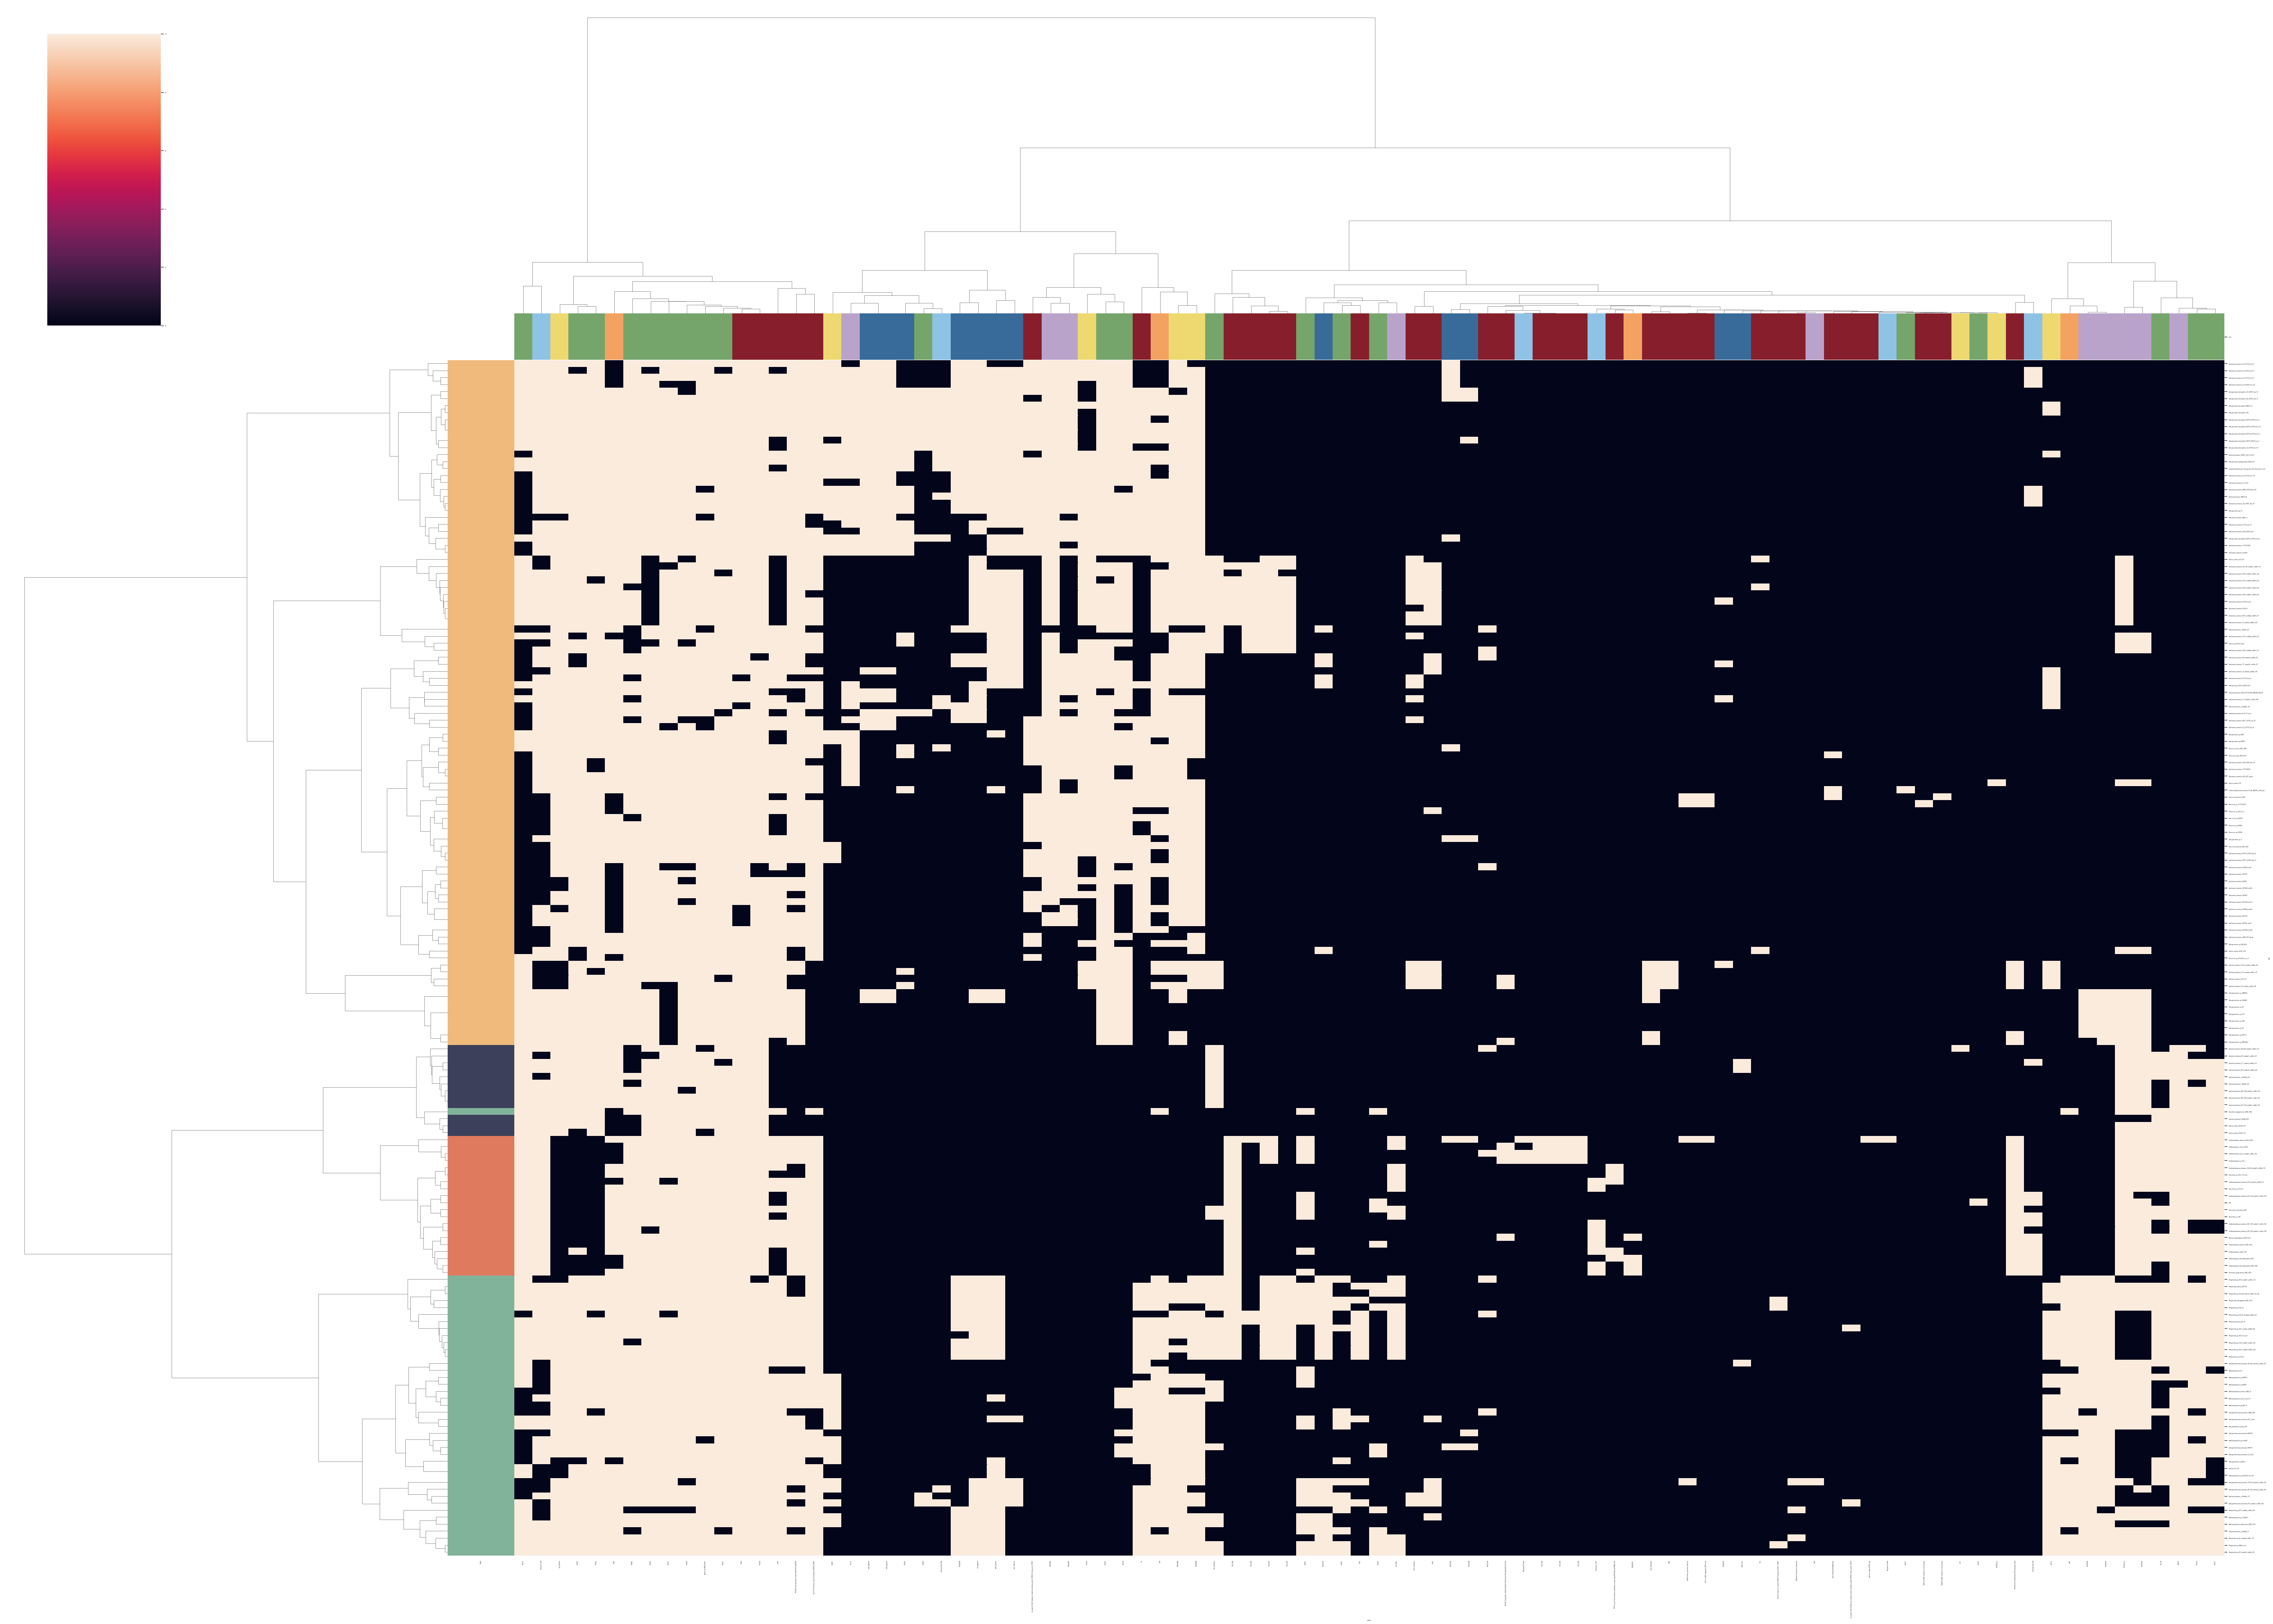

In [14]:
clustermap(
    data=heat_df,
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-complete.svg"
    ),
    dpi=300
)

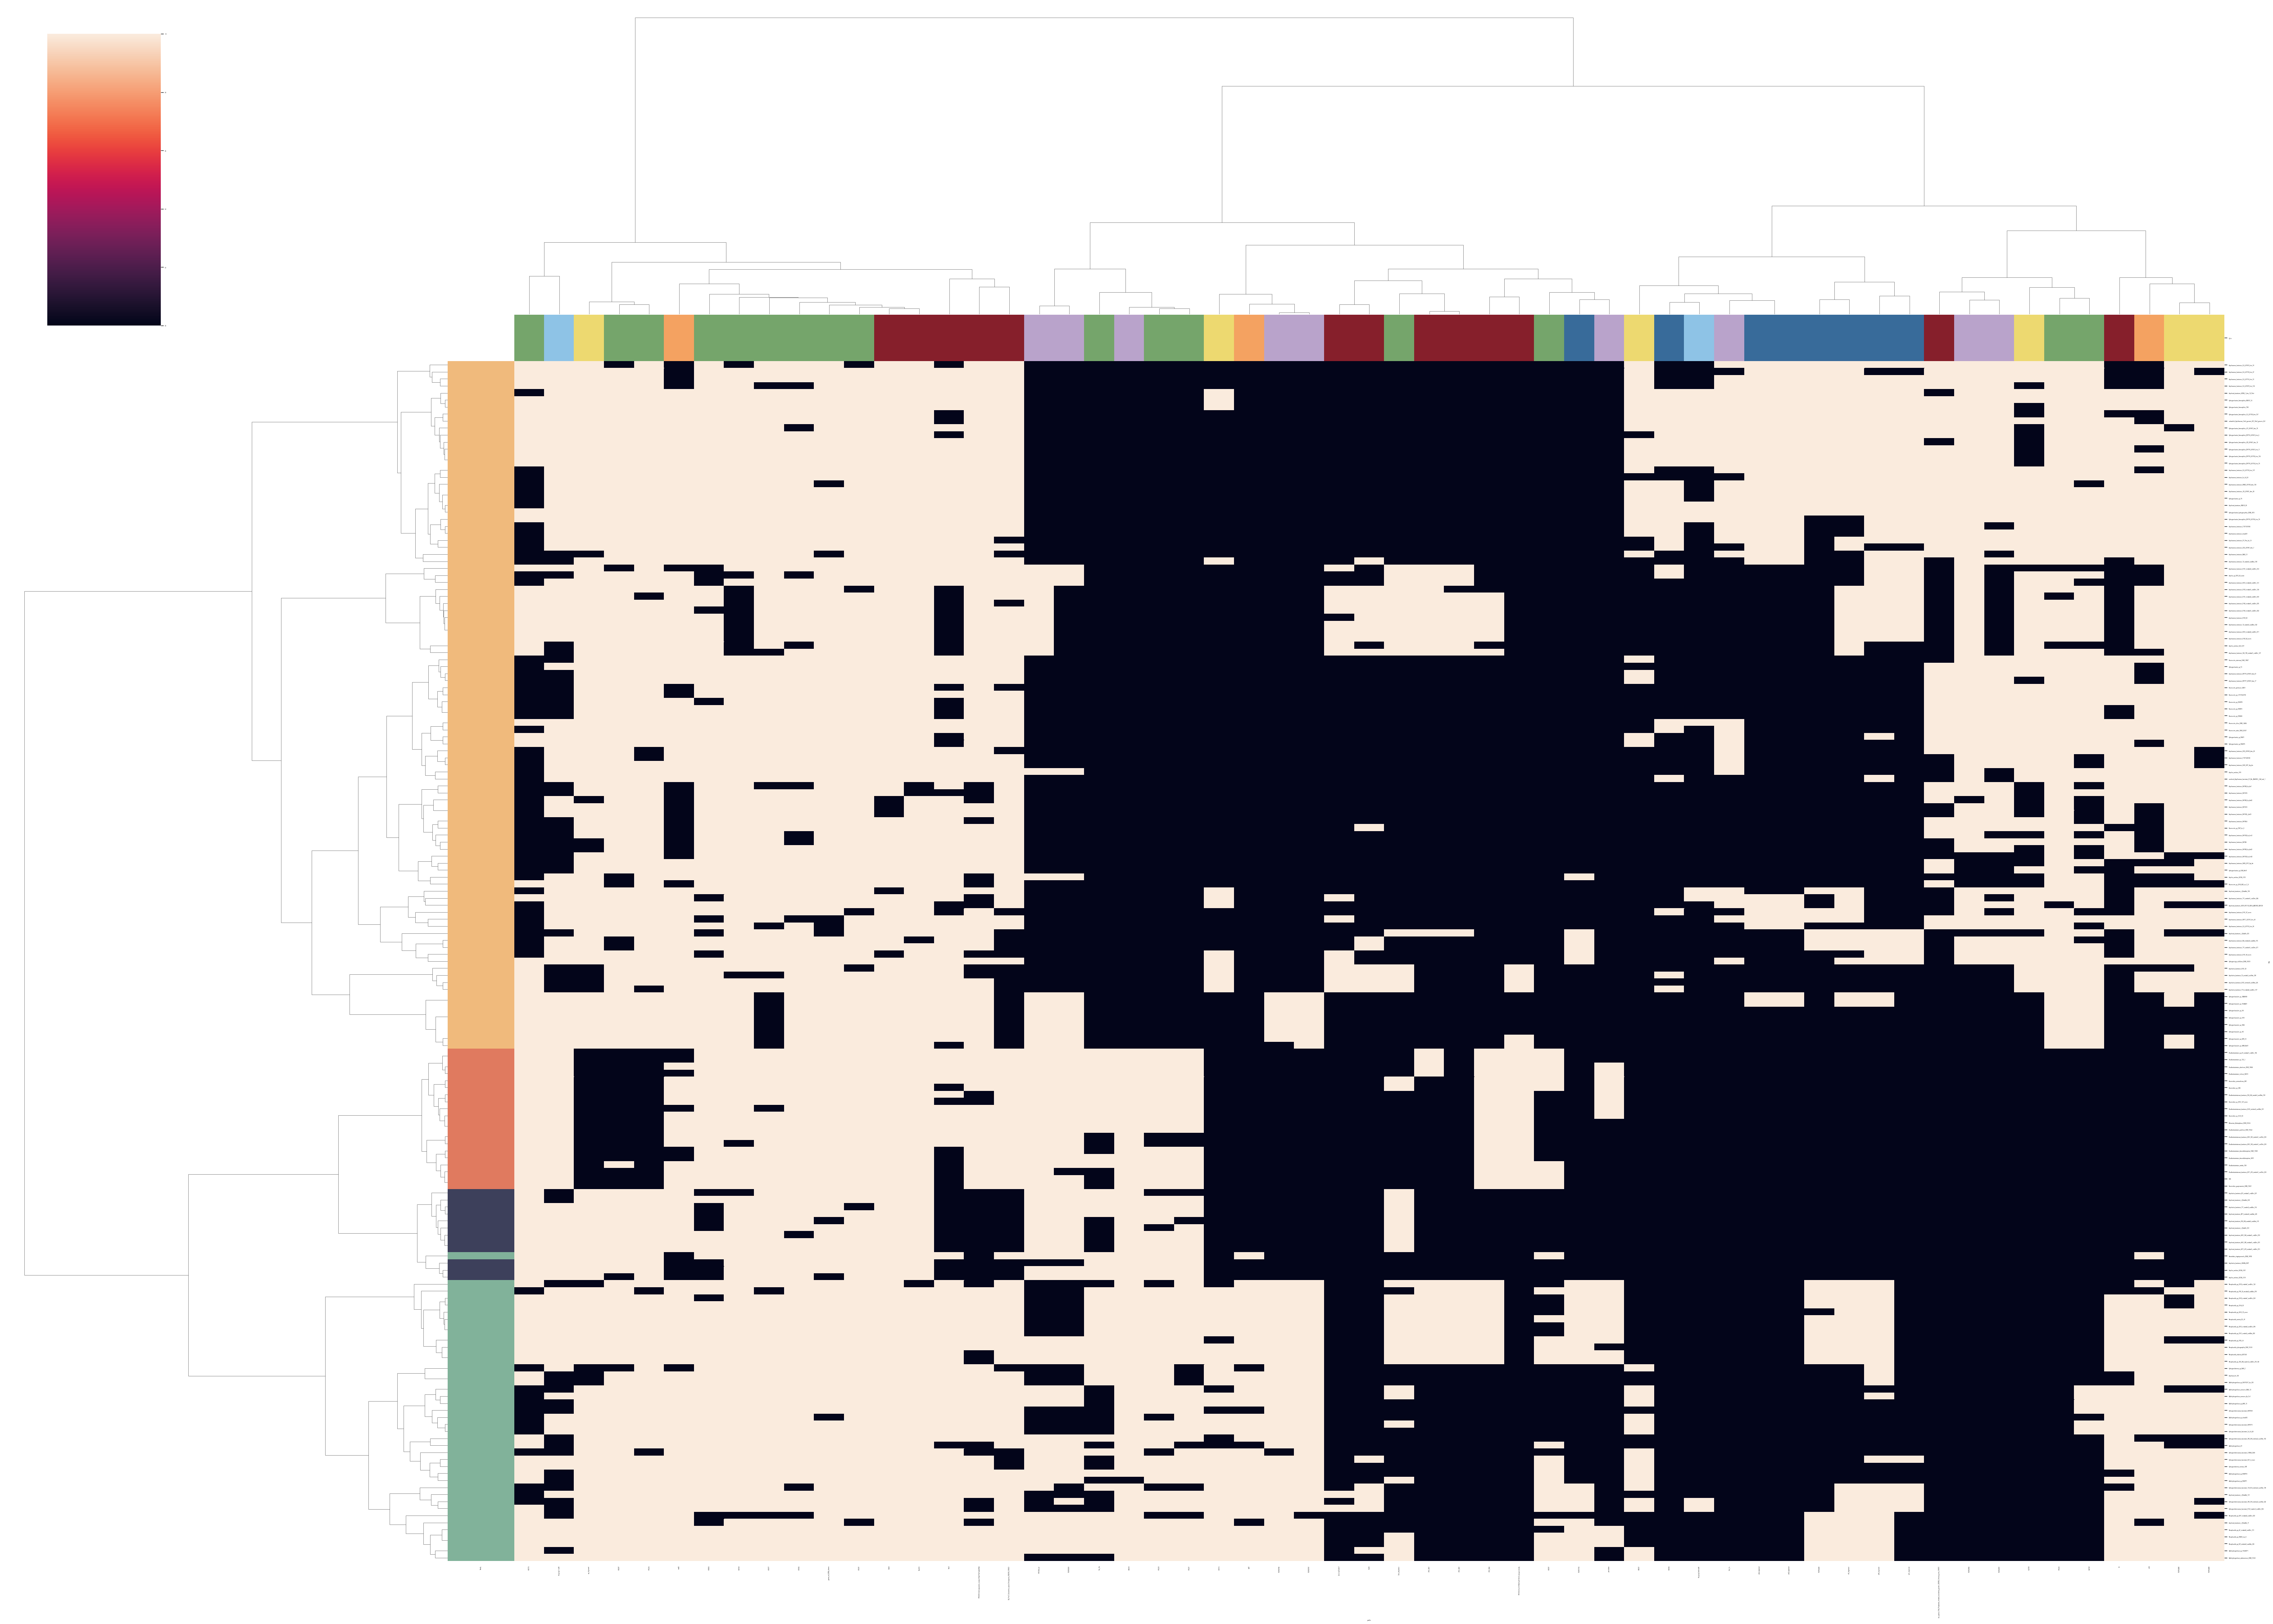

In [15]:
# Select columns that contain less that a proportion of zeroes
non_zero_columns = heat_df.columns[
    (heat_df == 0).mean() <= ABSENCE_THR
]
heat_df_nonzero = heat_df[non_zero_columns]

clustermap(
    data=heat_df_nonzero,
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-nonzero.svg"
    ),
    dpi=300
)

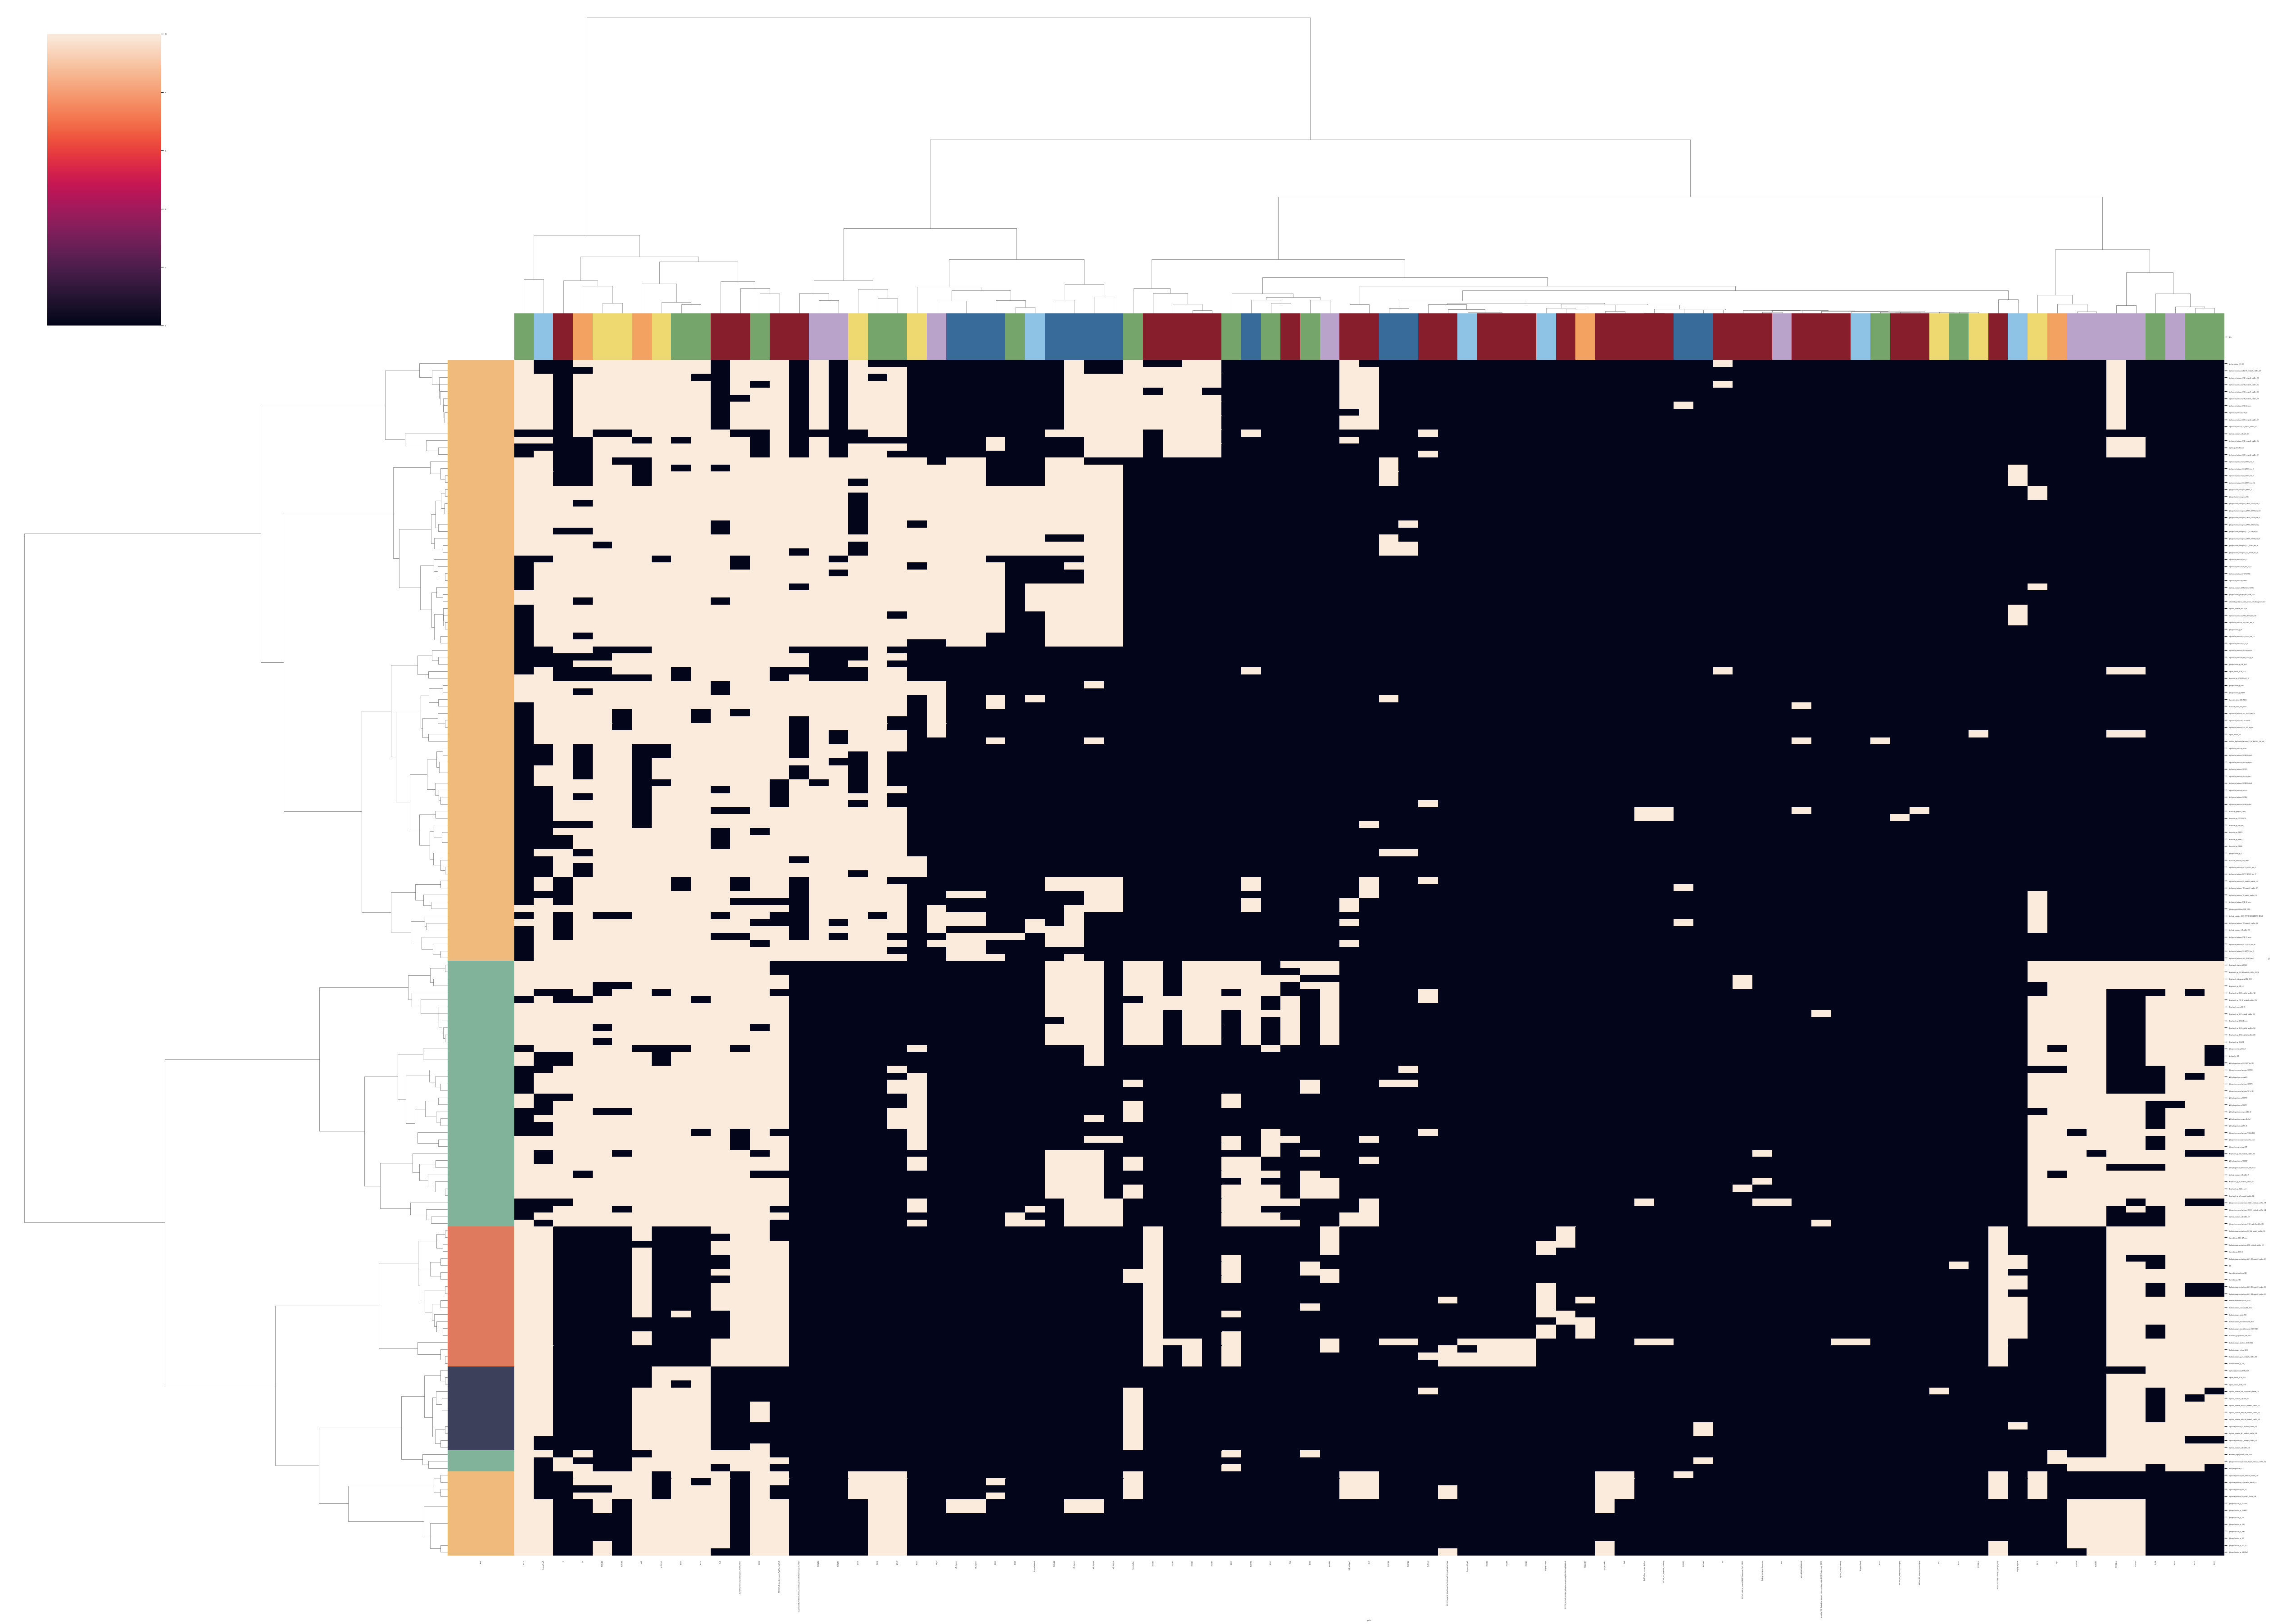

In [16]:
clustermap(
    data=heat_df.drop(core_hmms["hmm_model"].tolist(), axis=1),
    method=CLUSTERMAP_METHOD,
    metric=CLUSTERMAP_METRIC,
    row_colors=family_colors,
    col_colors=cycle_colors,
    figsize=(70, 50)
)
plt.savefig(
    os.path.join(
        DATA_DIR,
        f"heatmap-{'-'.join(SOURCES)}-accessory.svg"
    ),
    dpi=300
)

## Cycles clustermaps

[+] Clustermap for cycle Arsenic
[ERROR] Could not create clustermap for cycle Arsenic: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Carbon


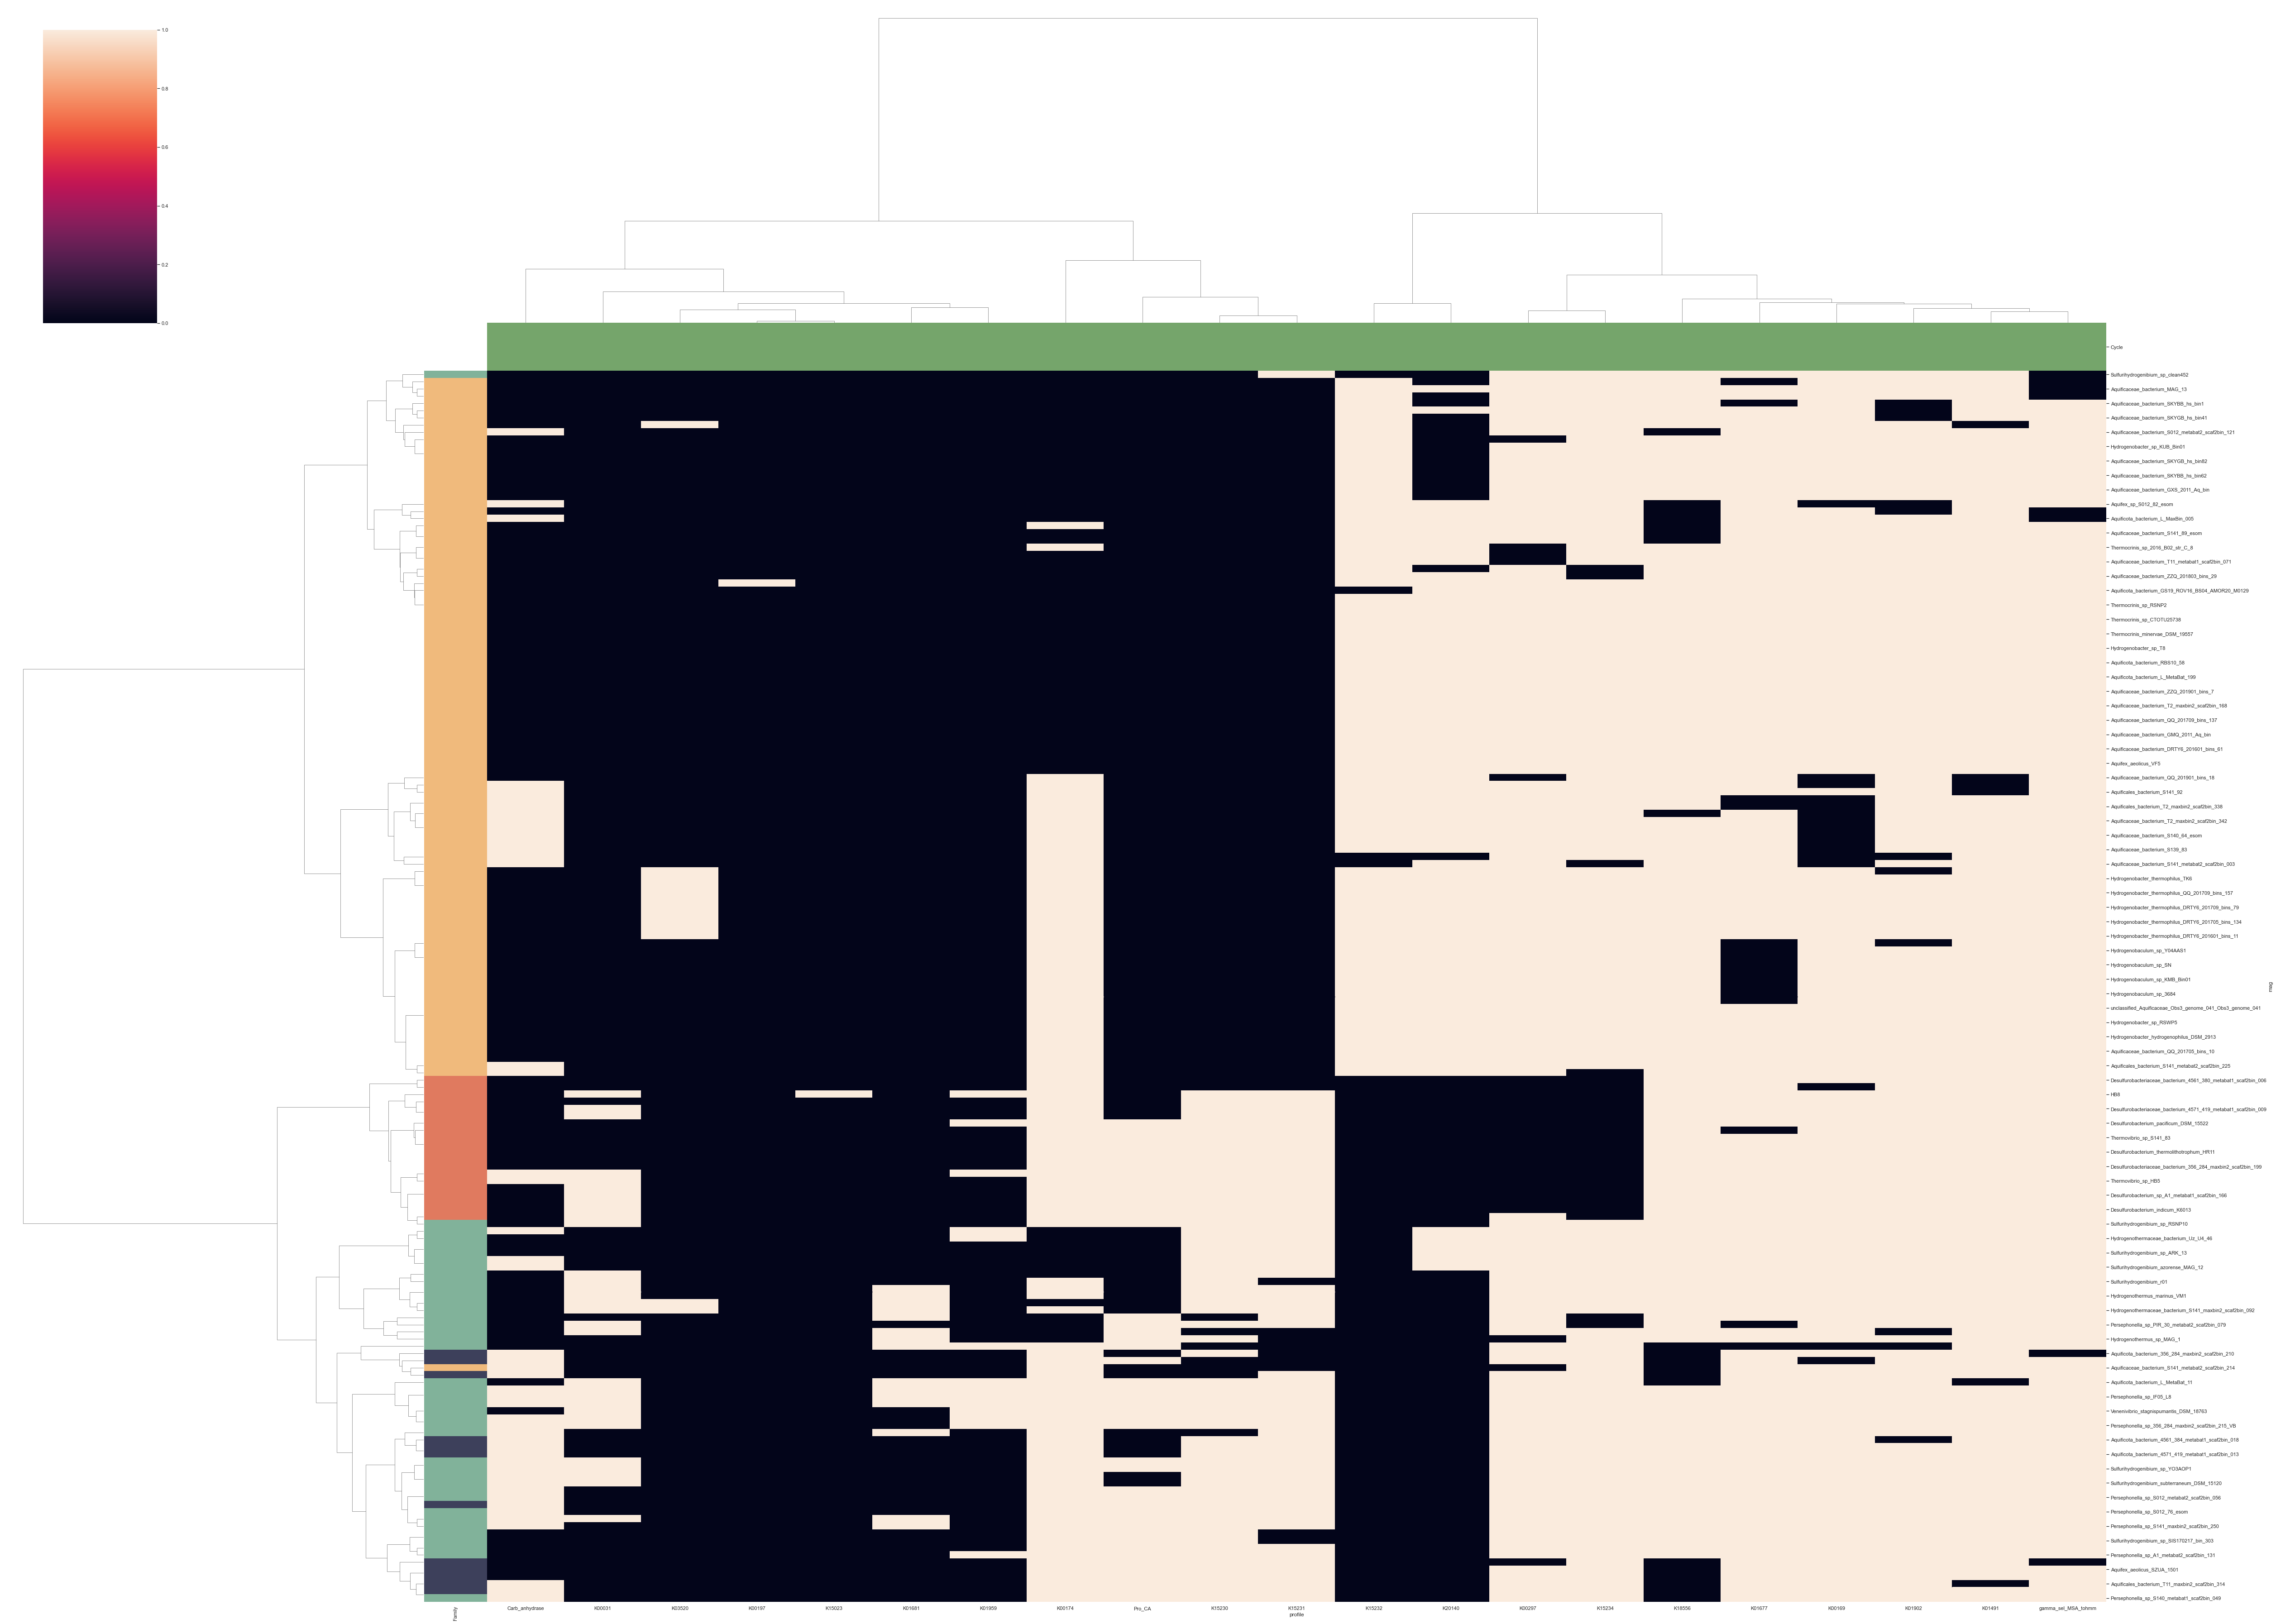

[+] Clustermap for cycle Methane
[ERROR] Could not create clustermap for cycle Methane: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Nitrogen


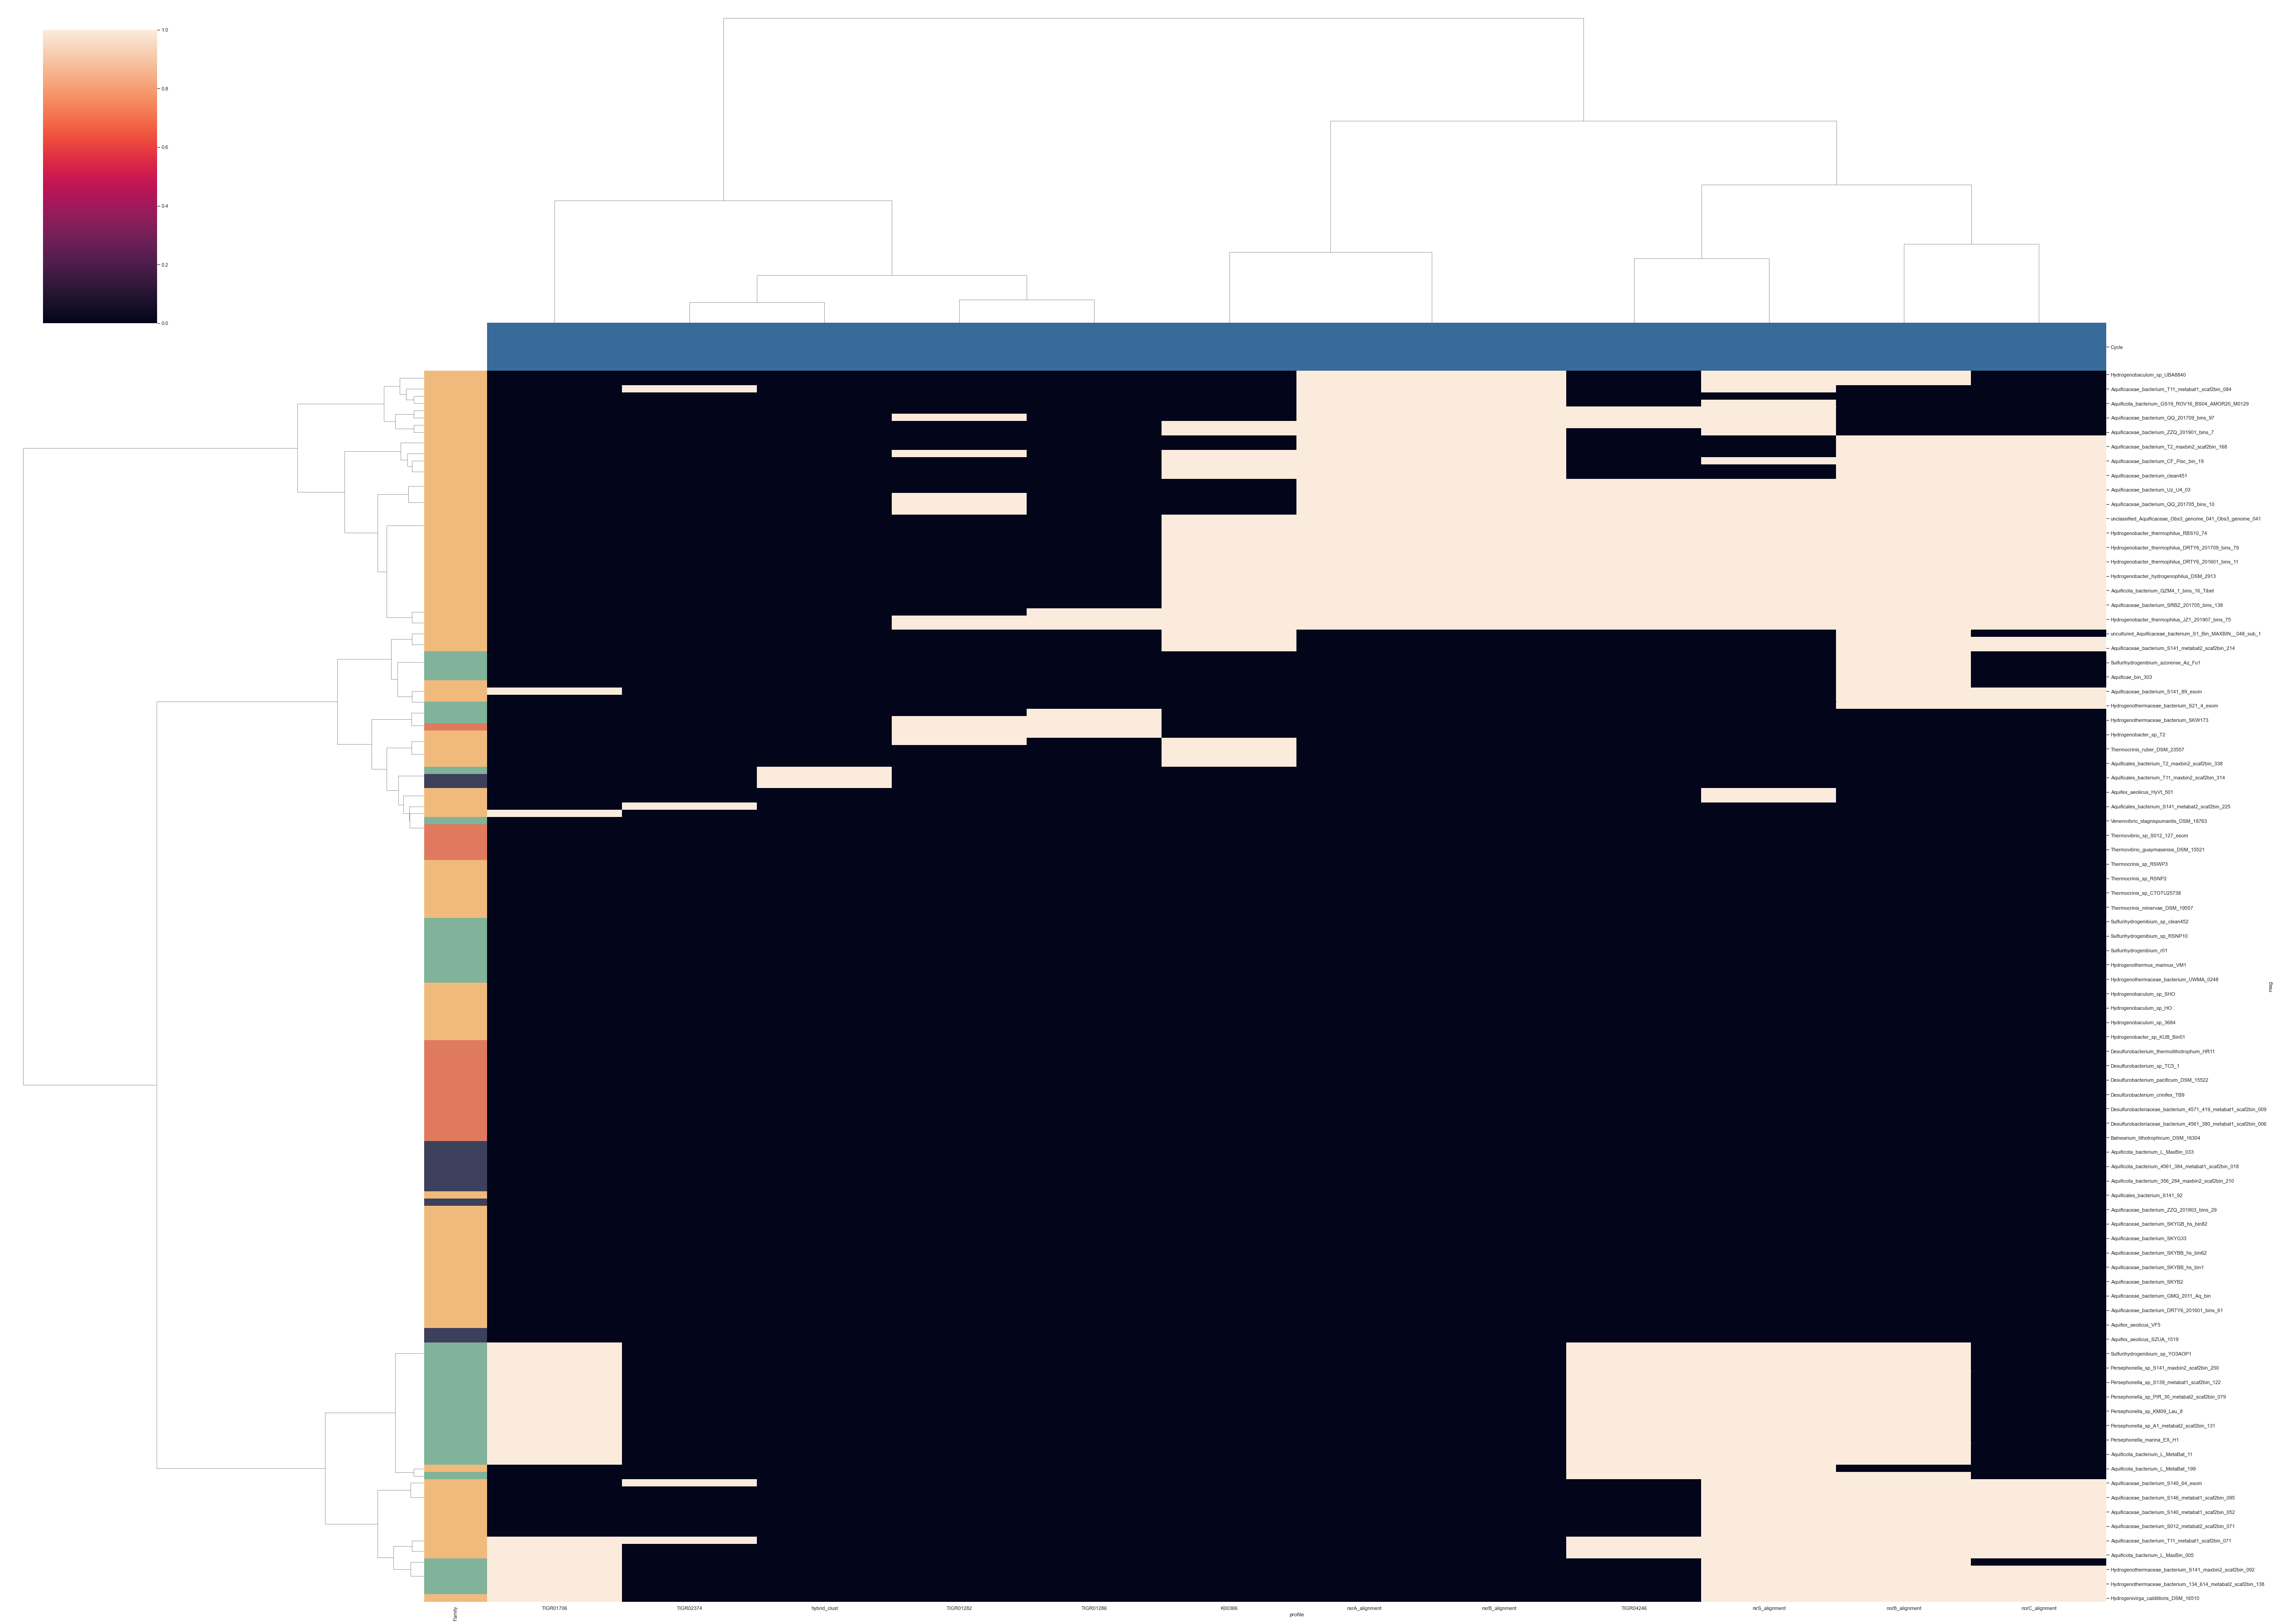

[+] Clustermap for cycle Oxygen


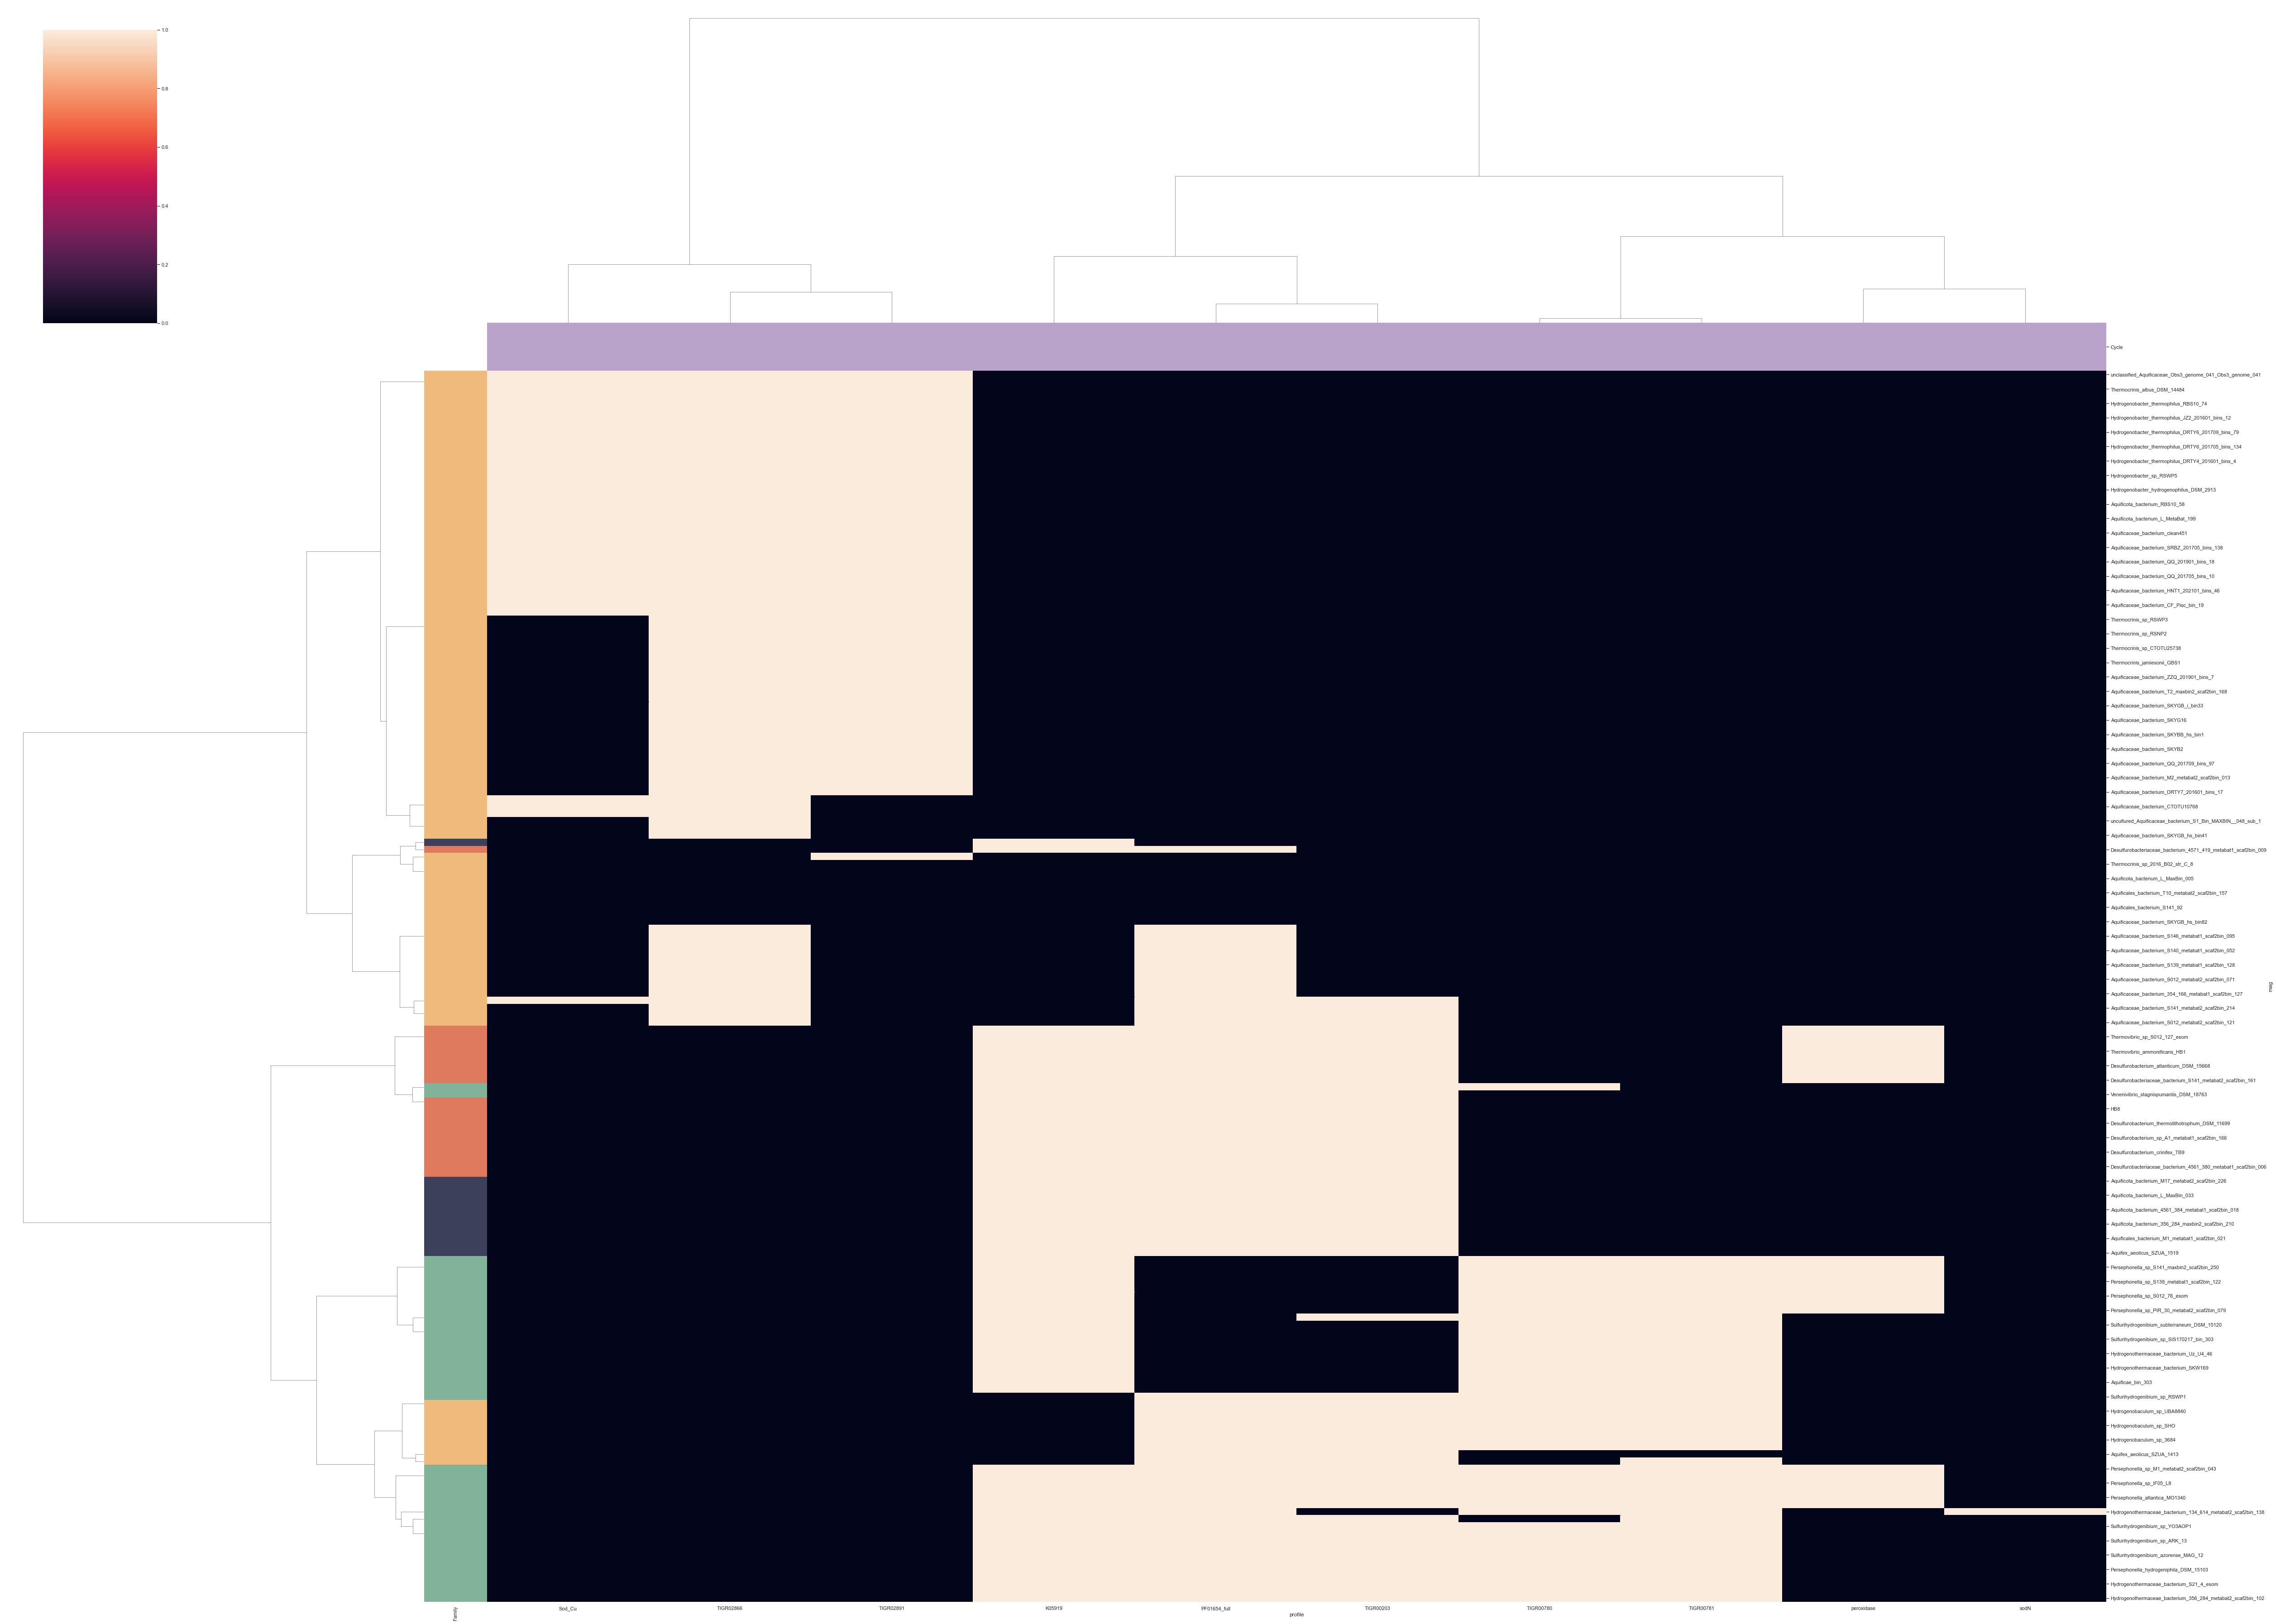

[+] Clustermap for cycle Photosynthesis
[ERROR] Could not create clustermap for cycle Photosynthesis: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Sulfur


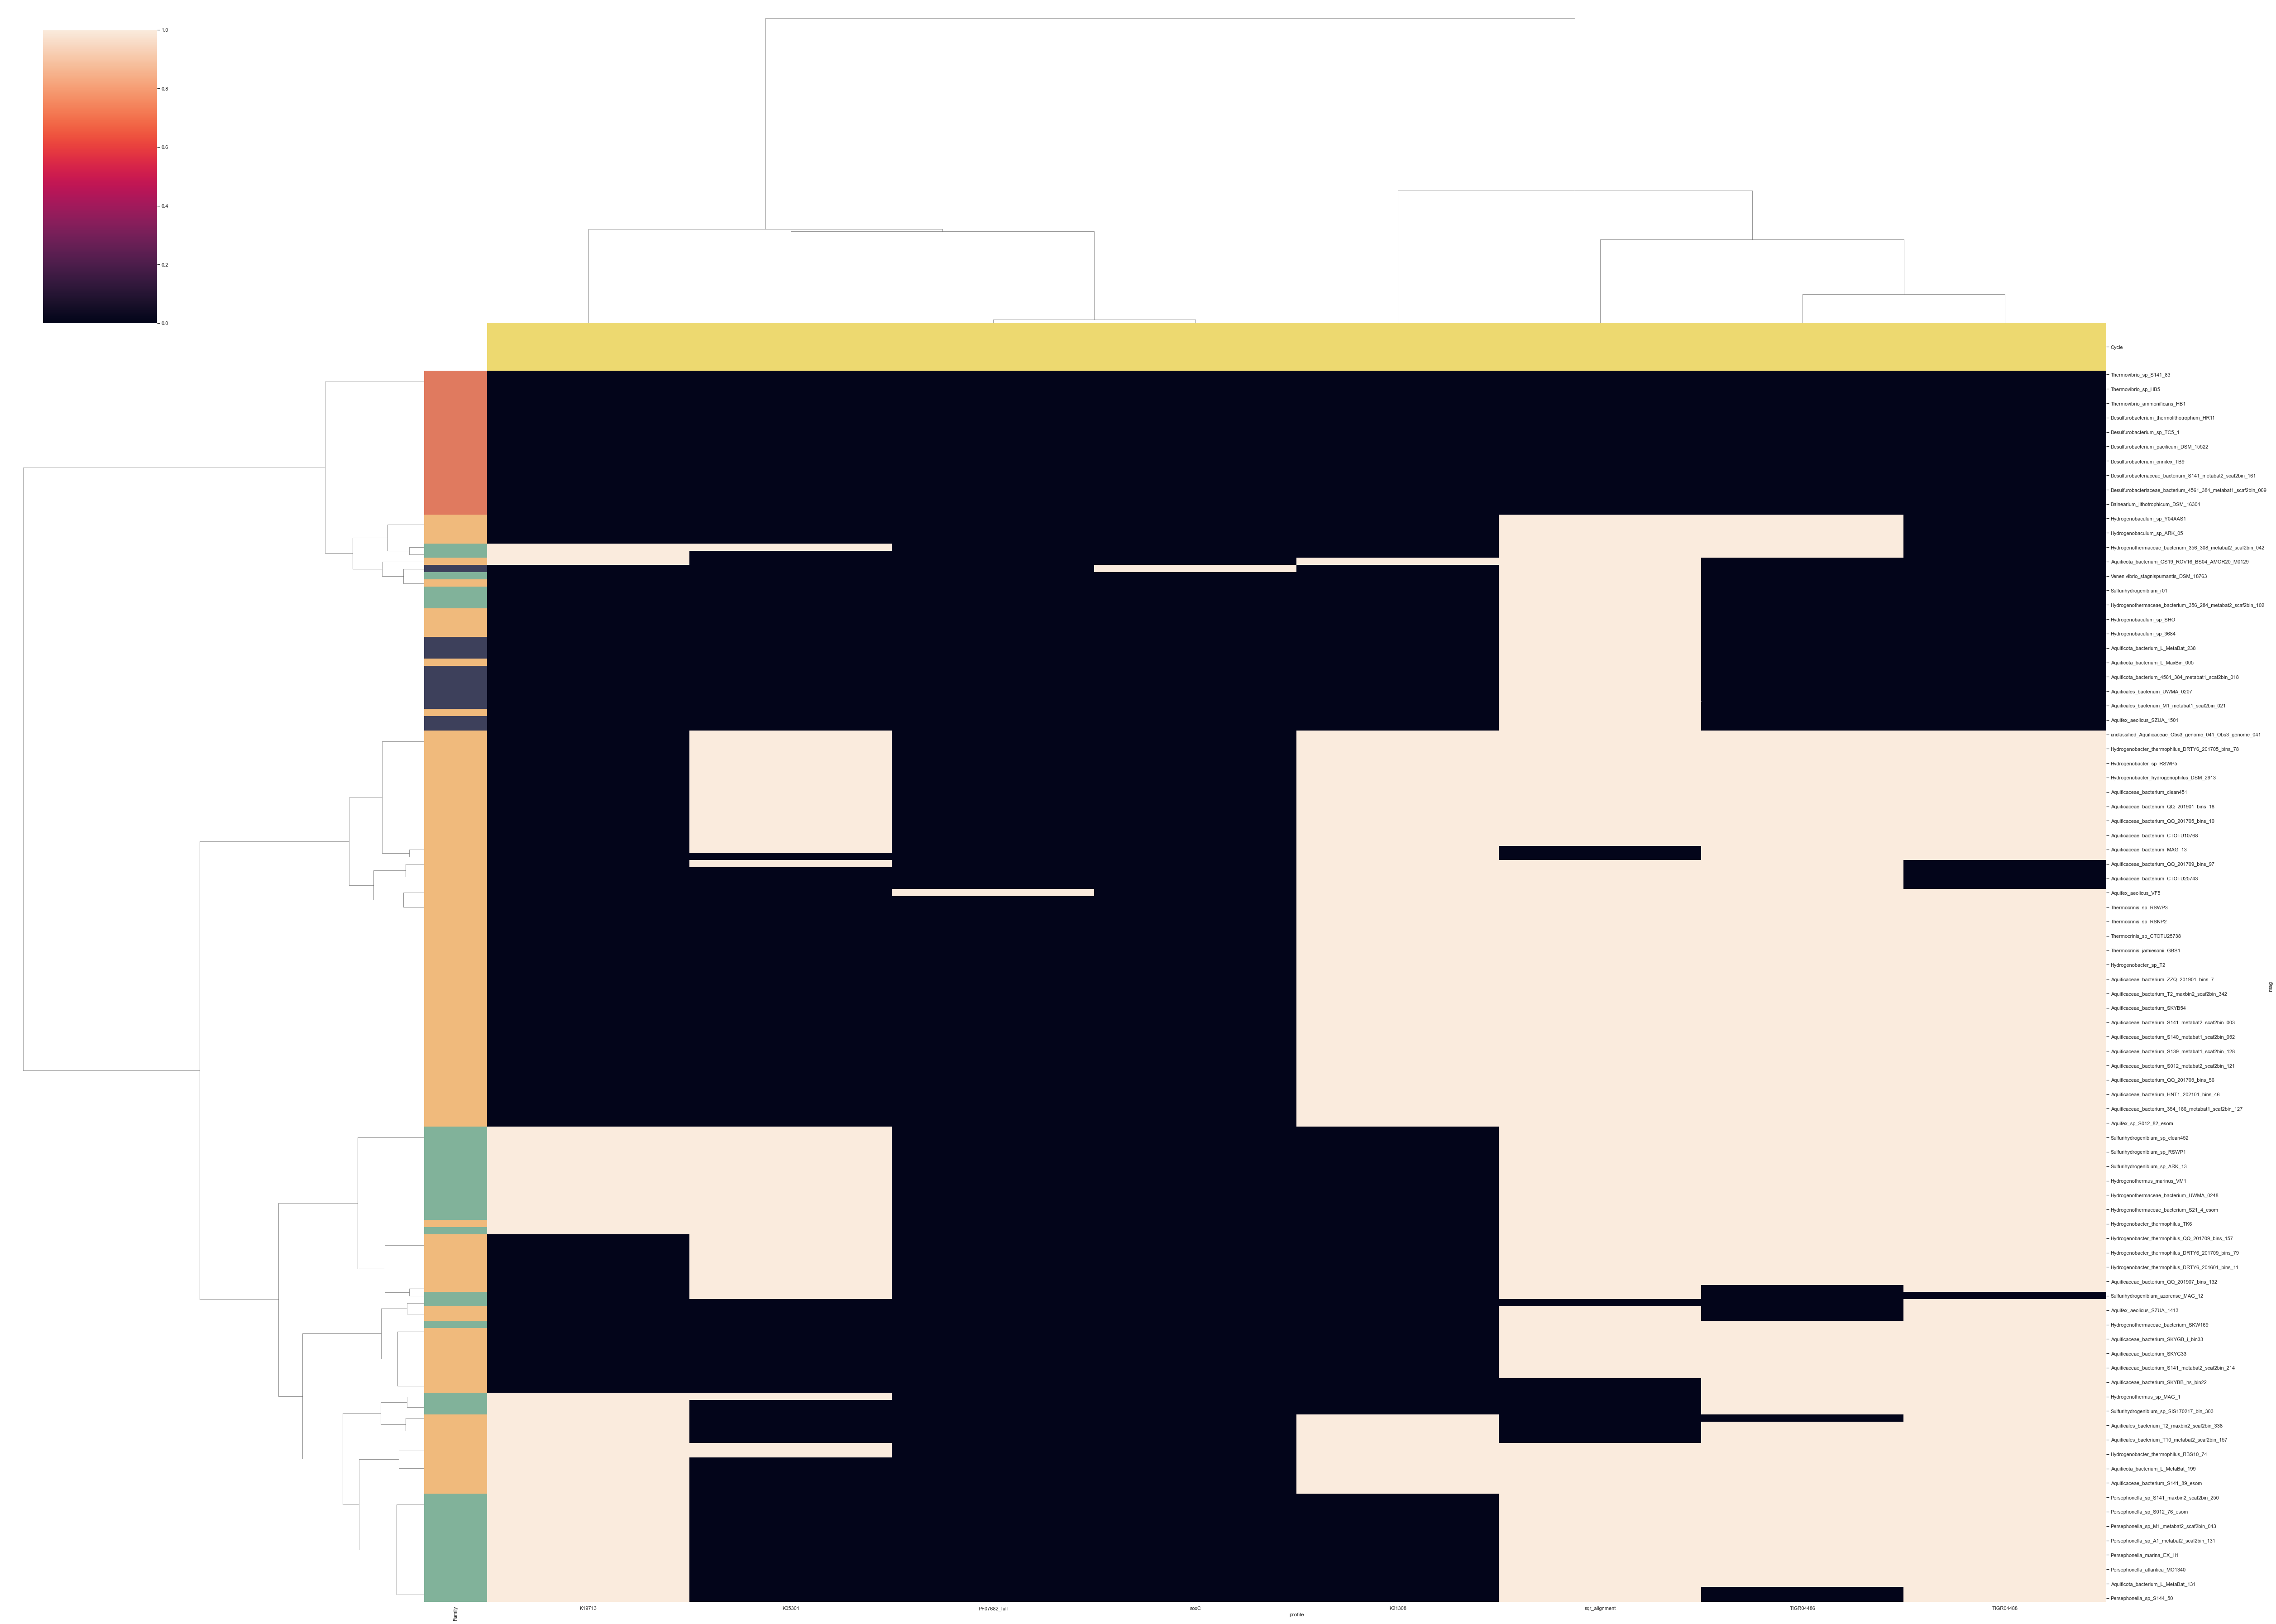

[+] Clustermap for cycle Transporters


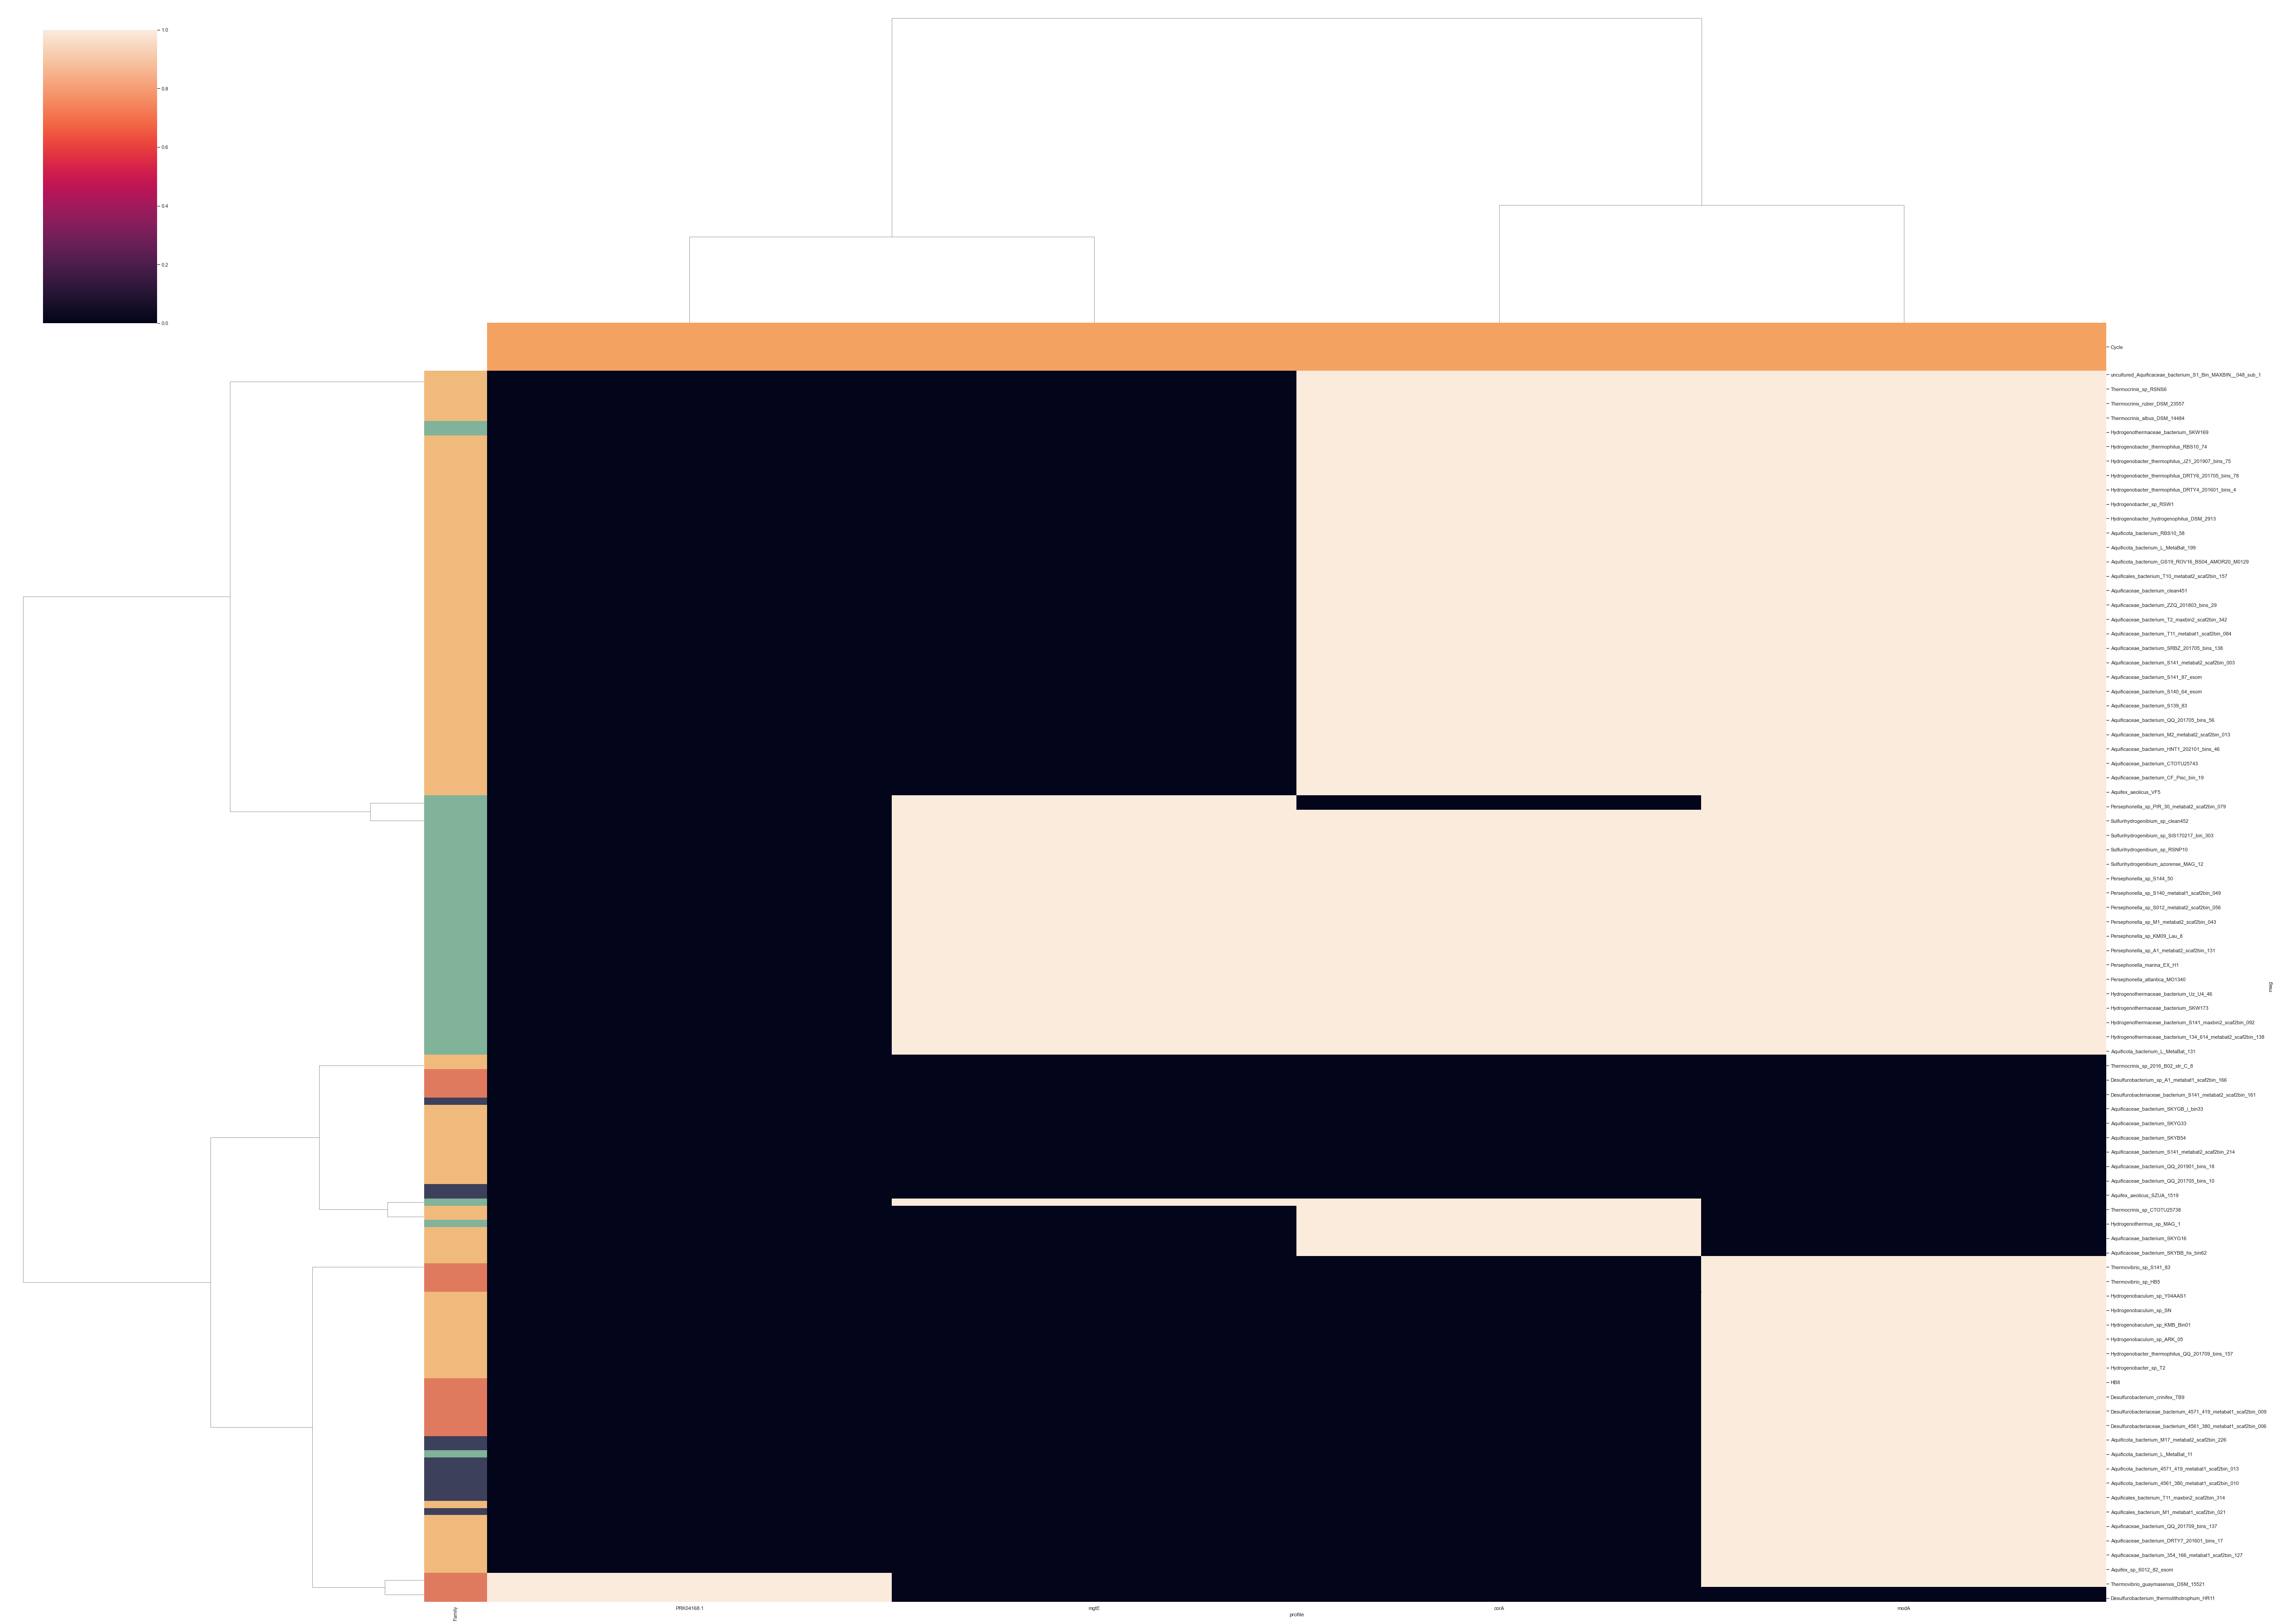

[+] Clustermap for cycle Hydrogen


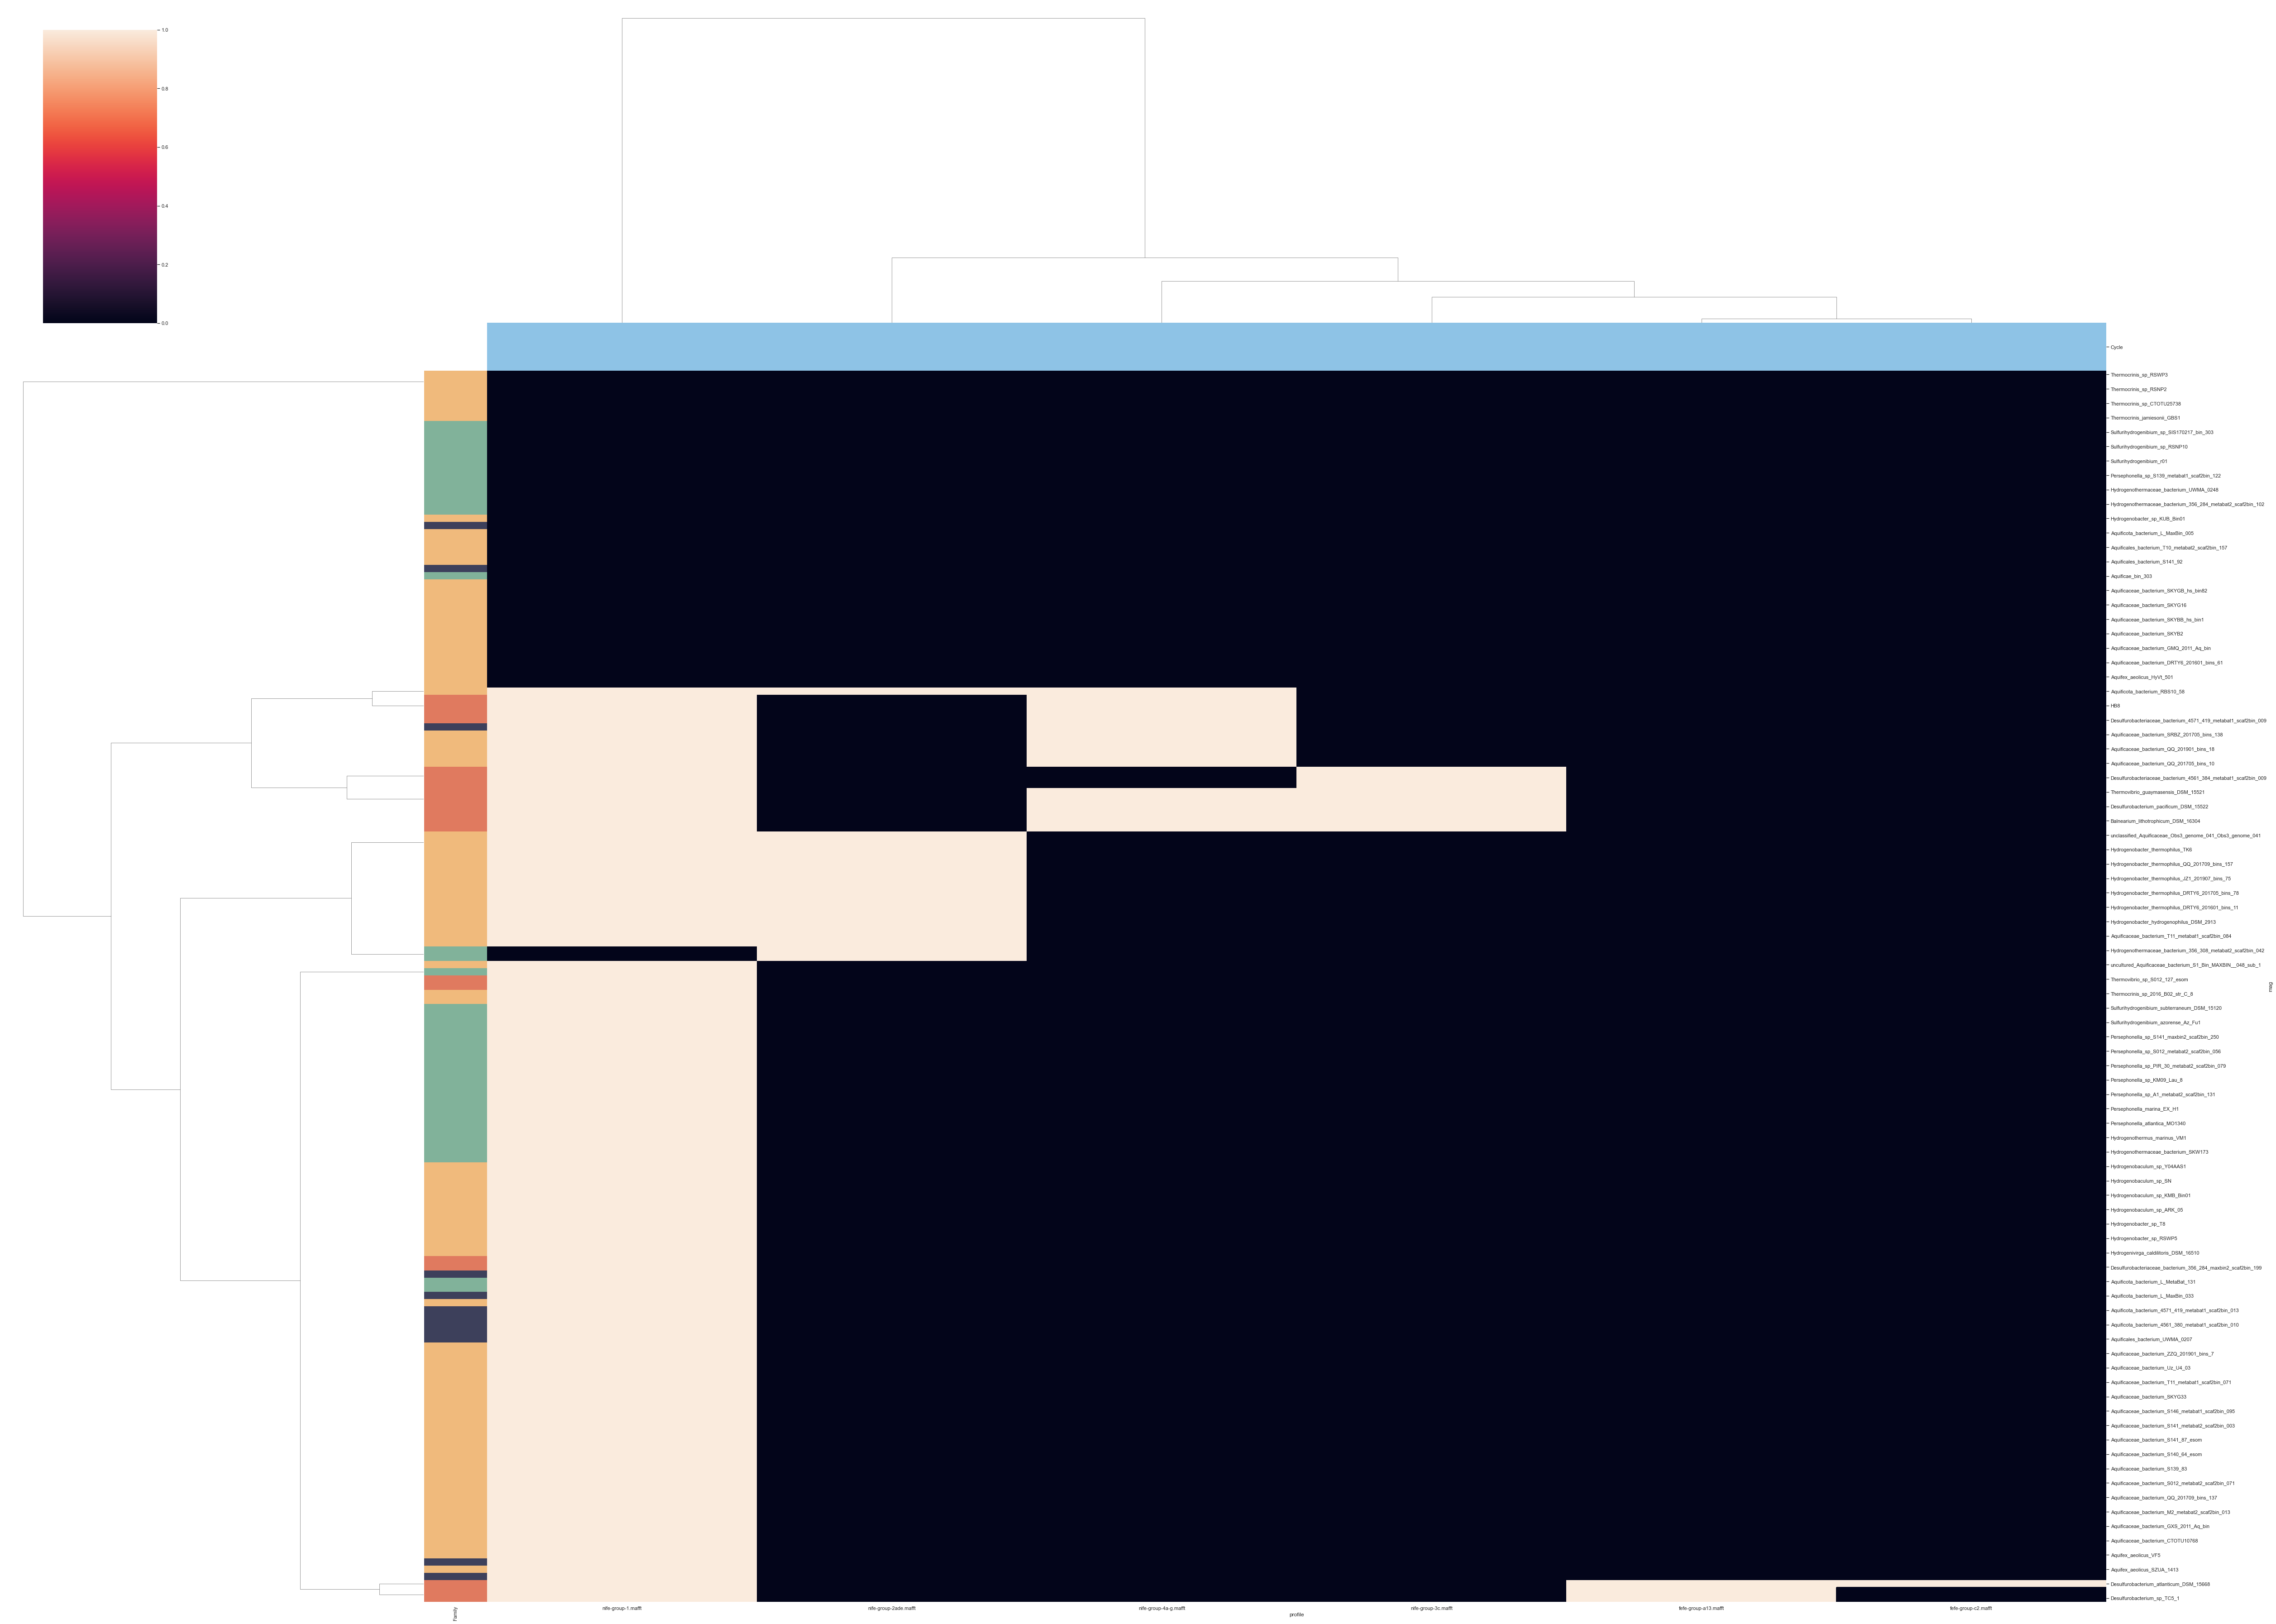

[+] Clustermap for cycle Selenium
[ERROR] Could not create clustermap for cycle Selenium: index 0 is out of bounds for axis 0 with size 0
[+] Clustermap for cycle Iron


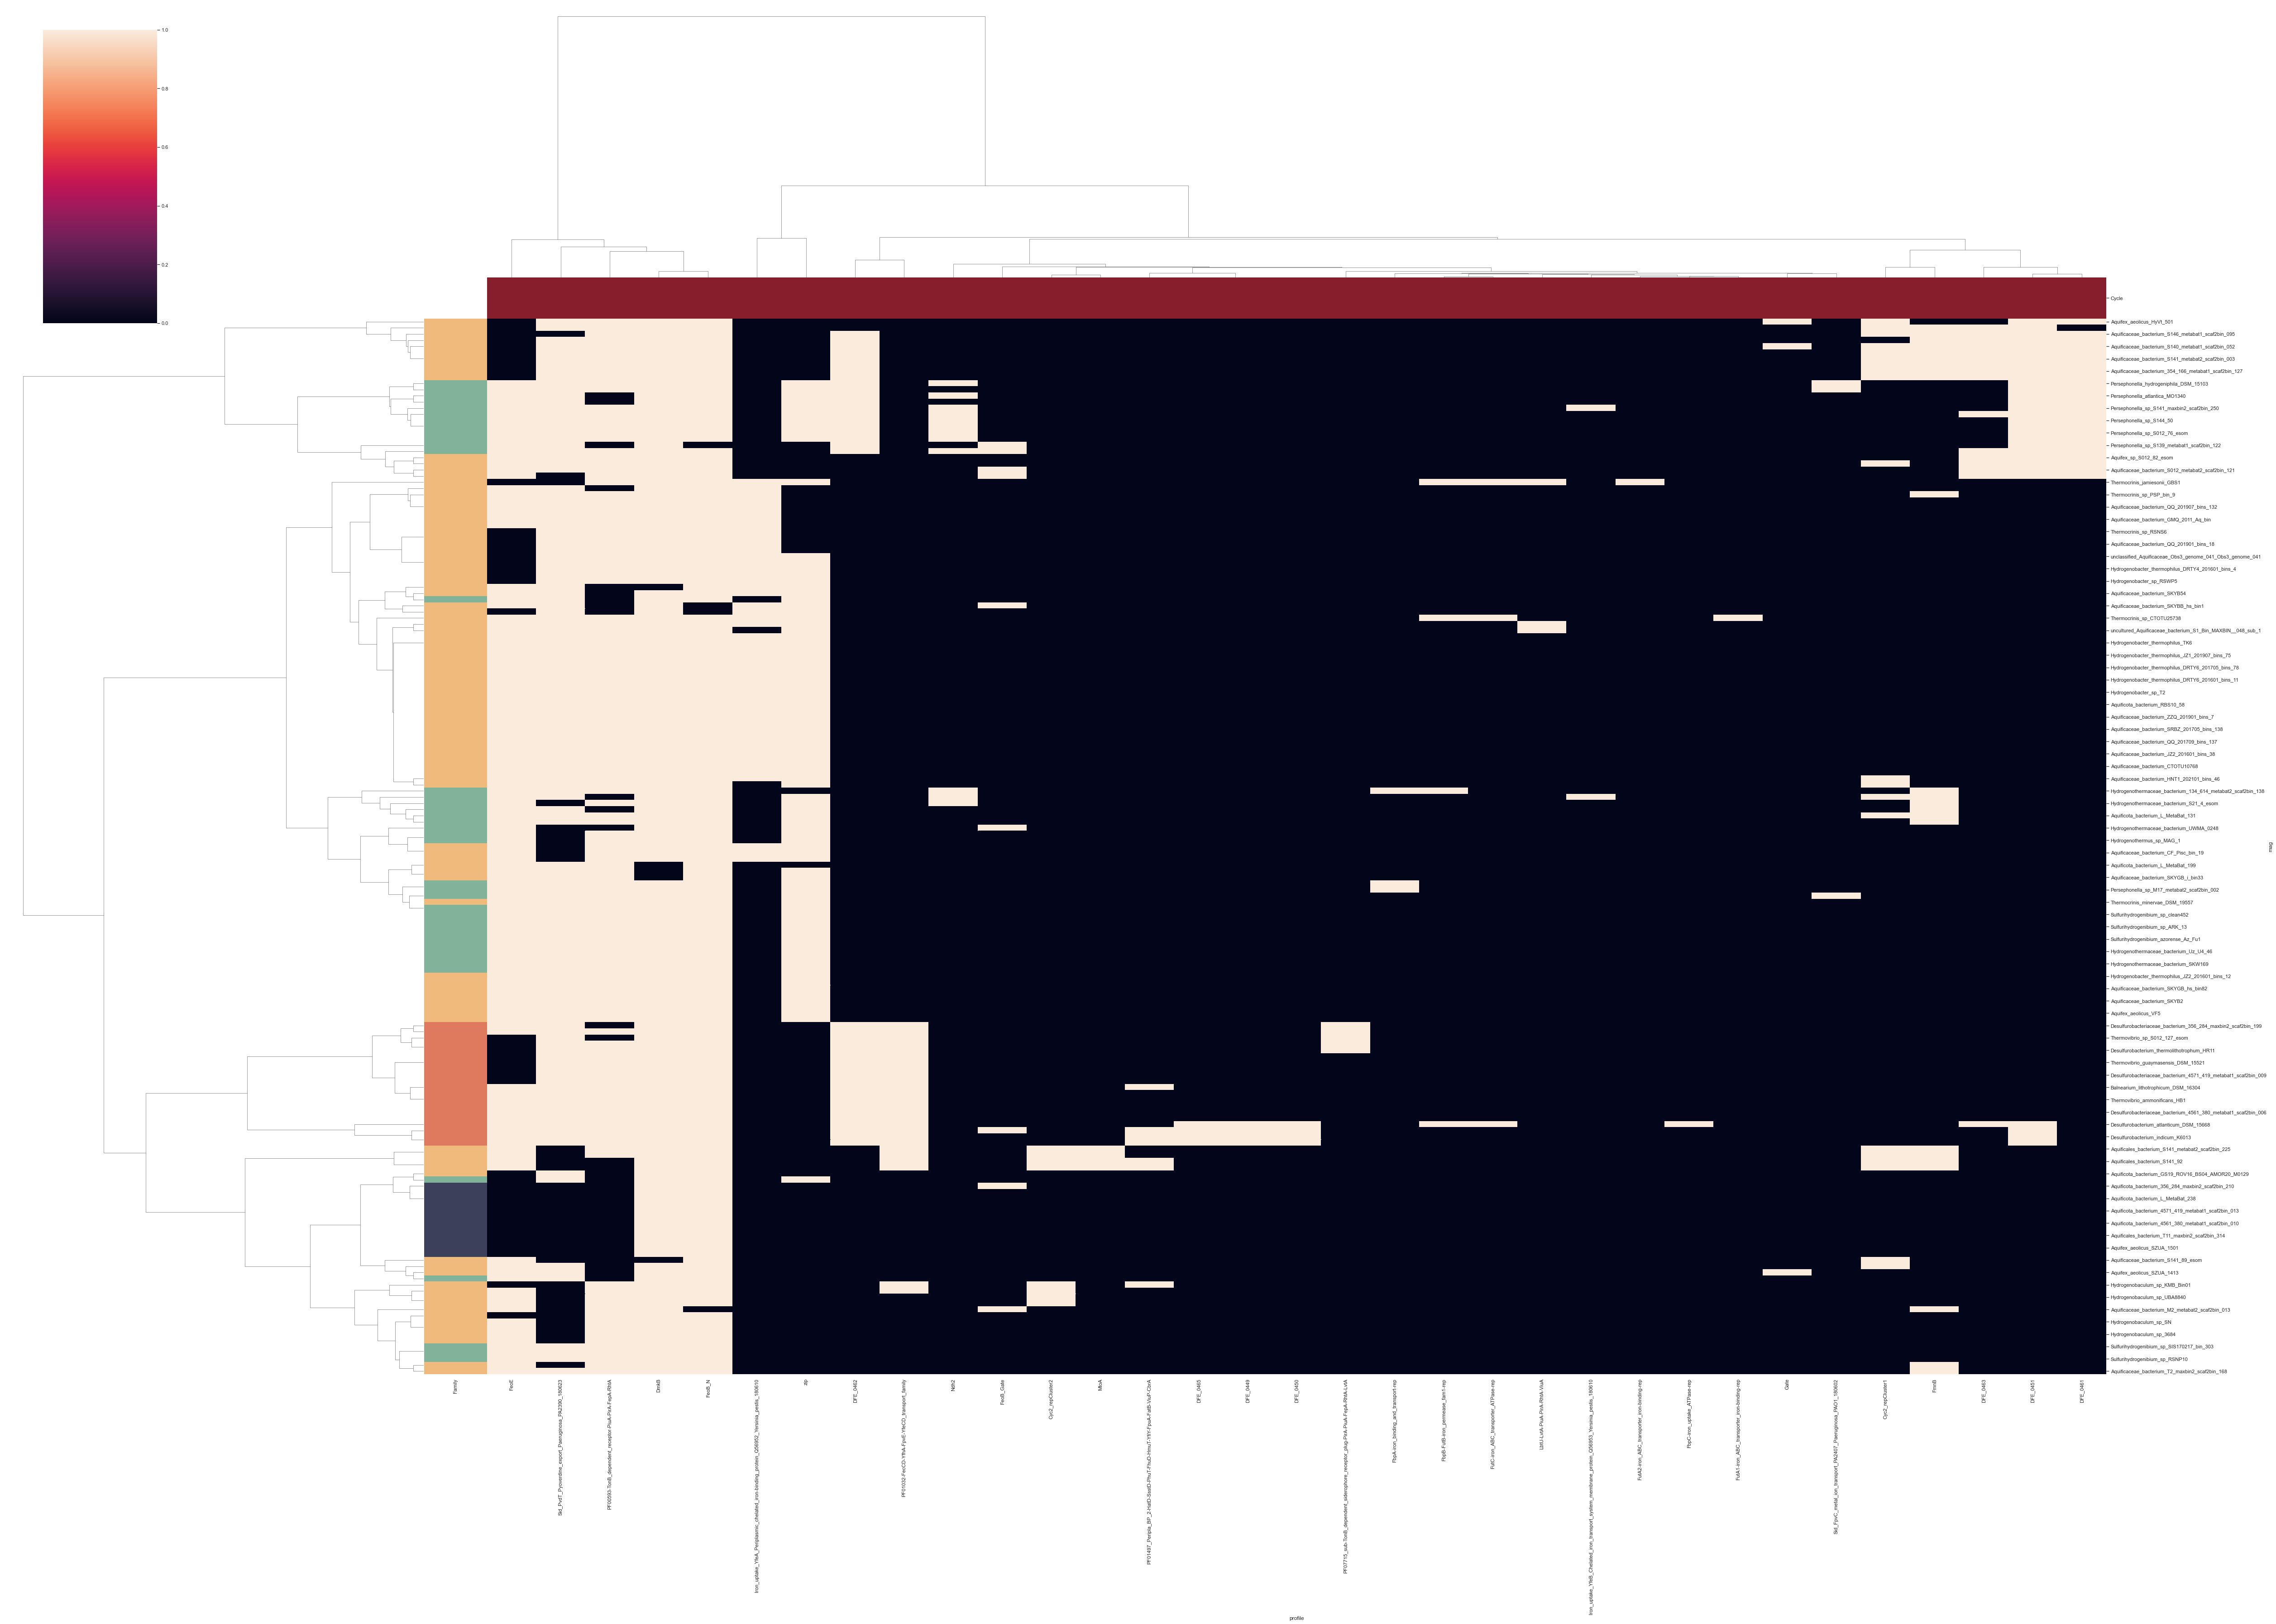

In [17]:
sns.set(font_scale=1.0)

for cycle in metadata_df["Cycle"].unique():

    cycle_hmm_models = metadata_df[
        metadata_df["Cycle"] == cycle
    ]["hmm_model"].unique()

    heat_df_cycle = heat_df[[
        col for col in heat_df.columns
        if col in cycle_hmm_models
    ]]

    try:
        print(f"[+] Clustermap for cycle {cycle}")
        sns.clustermap(
            data=heat_df_cycle,
            method=CLUSTERMAP_METHOD,
            metric=CLUSTERMAP_METRIC,
            col_colors=cycle_colors,
            row_colors=family_colors,
            figsize=(70, 50)
        )
        plt.savefig(
            os.path.join(
                DATA_DIR,
                f"heatmap-{'-'.join(SOURCES)}-cycle-{cycle.lower()}.svg"
            ),
            # dpi=300
        )
        plt.show()

    except Exception as error:
        print(f"[ERROR] Could not create clustermap for cycle {cycle}:", error)
        plt.close()


## HMM importances

In [18]:
def get_feat_imp(
    X: pd.DataFrame,
    y: pd.DataFrame,
    label_mapping: dict,
    bits_df: pd.DataFrame,
    sign_thr: float = SIGNIFICANCE_THR,
    test_check: str = "either",
    random_seed: int = RANDOM_SEED
) -> pd.DataFrame:

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.3,
        stratify=y,
        random_state=random_seed
    )

    estimator = RandomForestClassifier(
        n_estimators=5,
        random_state=RANDOM_SEED
    )
    estimator.fit(X_train, y_train)

    print(
        label_mapping,
        "\n",
        classification_report(
            y_true=y_test,
            y_pred=estimator.predict(X_test)
        )
    )

    result = permutation_importance(
        estimator,
        X_test,
        y_test,
        n_repeats=20,
        random_state=RANDOM_SEED,
        n_jobs=-1
    )

    forest_importances = pd.DataFrame({
        "feature": X_test.columns,
        "mean": result.importances_mean,
        "std": result.importances_std
    }).sort_values("mean", ascending=False)

    fig = px.bar(
        data_frame=forest_importances,
        x="feature",
        y="mean",
        error_y="std",
        labels={
            "feature": "HMM model",
            "mean": "Mean accuracy decrease",
            "std": "Mean accuracy decrease (std)"
        },
        title="HMM models - RF importances",
        template="plotly_white",
        height=900
    )
    fig.show()

    feat_imp = pd.DataFrame({
        "feature": X.columns,
        "mutual_info": fs.mutual_info_classif(
            X=X,
            y=y,
            discrete_features=True,
            n_neighbors=3,
            random_state=RANDOM_SEED
        )
    })

    # Add forest importances
    feat_imp = pd.merge(
        left=feat_imp,
        right=forest_importances\
            .drop("std", axis=1)\
            .rename(columns={"mean": "rf_importance_mean"}),
        on="feature",
        how="left"
    )

    # Add ANOVA and Chi2
    feat_imp[["anova_fvalue", "anova_pvalue"]] = \
        pd.DataFrame(fs.f_classif(X, y)).T
    feat_imp[["chi2", "chi2_pvalue"]] = \
        pd.DataFrame(fs.chi2(X, y)).T

    # Drop by significance threshold (must pass both tests)
    if test_check == "either":
        feat_imp = feat_imp[
            (feat_imp["anova_pvalue"] <= sign_thr) |
            (feat_imp["chi2_pvalue"] <= sign_thr)
        ]
    elif test_check == "both":
        feat_imp = feat_imp[
            (feat_imp["anova_pvalue"] <= sign_thr) &
            (feat_imp["chi2_pvalue"] <= sign_thr)
        ]
    else:
        raise NotImplementedError

    # Sort values
    feat_imp = feat_imp.sort_values("anova_fvalue", ascending=False)

    feat_imp = feat_imp.melt(
        id_vars=["feature"],
        var_name="statistic",
        value_vars=[
            "rf_importance_mean",
            "mutual_info",
            "anova_fvalue",
            "chi2"
        ],
        value_name="value"
    )

    fig = px.bar(
        data_frame=feat_imp,
        x="feature",
        y="value",
        color="statistic",
        labels={
            "feature": "HMM model",
            "value": "Value",
            "statistic": "Statistic"
        },
        barmode="group",
        title="HMM models - Statistics",
        template="plotly_white",
        height=1200
    )
    fig.show()

    feat_imp_bitscore = bits_df[
        bits_df["query_name"].isin(feat_imp["feature"].unique())
    ]

    feat_imp_order = feat_imp[
        feat_imp["statistic"] == "anova_fvalue"
    ]["feature"].tolist()

    fig_box = px.box(
        data_frame=feat_imp_bitscore,
        x="query_name",
        y="score_full_seq"
    )
    fig_scatter = px.scatter(
        data_frame=feat_imp_bitscore,
        x="query_name",
        y="Hmm detecting threshold",
        color_discrete_sequence=["red"]
    )
    fig = go.Figure(data=fig_box.data + fig_scatter.data)
    fig.update_layout(
        title="Distribution of bitscores and their respectives thresholds",
        template="plotly_white",
        height=900
    )
    fig.update_xaxes(
        categoryorder="array",
        categoryarray=feat_imp_order
    )
    fig.show()

    return feat_imp

In [19]:
X = heat_df.copy()

#### Label: families

In [20]:
# Get families in the same order as in heat_df
y = tax_df.set_index("Genomes").loc[heat_df.index]["Family"]

# Encode as categories
family_mapping = {family: idx for idx, family in enumerate(y.unique())}
y = y.map(family_mapping)

In [21]:
feat_imp = get_feat_imp(
    X=X,
    y=y,
    label_mapping=family_mapping,
    bits_df=hits_df_nobitscore
)

{'Aquificaceae': 0, 'QOAS01': 1, 'Hydrogenothermaceae': 2, 'Desulfurobacteriaceae': 3} 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        30
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00         6

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



#### Label: aerobic/anaerobic

In [22]:
# Get in the same order as in heat_df
y_aero = tax_df.set_index("Genomes").loc[heat_df.index]["Family"]

# Encode as categories
aerobic_mapping = {
    "Desulfurobacteriaceae": 0,
    "Hydrogenothermaceae": 1,
    "Aquificaceae": 1,
    "QOAS01": 0
}
y_aero = y_aero.map(aerobic_mapping)

In [23]:
feat_imp_aero = get_feat_imp(
    X=X,
    y=y_aero,
    label_mapping=aerobic_mapping,
    bits_df=hits_df_nobitscore
)

{'Desulfurobacteriaceae': 0, 'Hydrogenothermaceae': 1, 'Aquificaceae': 1, 'QOAS01': 0} 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        42

    accuracy                           1.00        52
   macro avg       1.00      1.00      1.00        52
weighted avg       1.00      1.00      1.00        52



## Get CSV with the data from significant hits

#### Separating between families

In [24]:
# Format rows
feat_imp["feature"] = feat_imp["feature"].str.replace("barosa_", "")

# Merge with the metadata df to better parse the significant values
merged_families = pd.merge(
    feat_imp, 
    metadata_df, 
    how="left", 
    left_on="feature", 
    right_on="hmm_model"
)
merged_families.to_csv(
    os.path.join(
        DATA_DIR,
        f"families_top_hits_3.csv"
    ),
    index=False,
)

#### Separating aerobic versus anaerobic

In [25]:
# Format rows
feat_imp_aero["feature"] = feat_imp_aero["feature"].str.replace("barosa_", "")

# Merge with the metadata df to better parse the significant values
merged_aerobic = pd.merge(
    feat_imp_aero, 
    metadata_df, 
    how="left", 
    left_on="feature", 
    right_on="hmm_model"
)

merged_aerobic.to_csv(
    os.path.join(
        DATA_DIR,
        f"aerobic_top_hits.csv"
    ),
    index=False,
)

## Creating tree annotations

In [26]:
tree = Phylo.read(
    file=os.path.join(
        DATA_DIR,
        TREE_FILE
    ),
    format="newick"
)

##### Get the accurate family names

In [27]:
tree_df = pd.DataFrame.from_dict({
    "genome_name": [branch.name for branch in tree.get_terminals()]
})
tree_df

genome_name
0                            Aquifex_aeolicus_HyVt_501
1       Aquificaceae_bacterium_T2_maxbin2_scaf2bin_342
2    Aquificaceae_bacterium_S012_metabat2_scaf2bin_071
3                       Aquificaceae_bacterium_S139_83
4    Aquificaceae_bacterium_S139_metabat1_scaf2bin_128
..                                                 ...
170                        Desulfurobacterium_sp_TC5_1
171                    Thermotoga_caldifontis_AZM44c09
172                       Thermotoga_profunda_AZM34c06
173                           Thermotoga_maritima_MSB8
174                        Thermotoga_neapolitana_LA10

[175 rows x 1 columns]

In [28]:
id_matches = pd.merge(
    left=tree_df,
    right=tax_df.rename(columns={"Genomes": "genome_name"}),
    on="genome_name",
    how="left",
    indicator="merge"
)
id_matches = id_matches.drop_duplicates(subset="genome_name")

id_matches[id_matches["merge"] != "both"]["genome_name"]

Series([], Name: genome_name, dtype: object)

### Create the iTOL template


In [29]:
from modules.itol import get_itol_template


template_path = os.path.join(
    "../data/itol/",
    "itol-annotation-template.txt"
)

#### Annotation: metal

In [30]:
metal_df = hits_df.copy()

# Remove gene caller ID from MAG ID
metal_df["target_name"] = metal_df["target_name"].apply(
    lambda row: "_".join(row.split("_")[:-1])
)
metal_df = metal_df.rename(columns={"target_name": "genome_name"})

# Format metal column
metal_df["cofactor"] = metal_df["Catalyst_metal"]\
    .str.replace("NiFe", "Ni,Fe")\
    .str.replace("Fe(III)", "Fe")\
    .str.replace("Fe / Mn", "Fe,Mn")\
    .str.replace("Fe, Mn", "Fe,Mn")\
    .str.replace("Fe ", "Fe")\
    .str.replace("FeFe", "Fe")\
    .str.replace("Mo, W", "Mo,W")\
    .str.replace("//NAD+", "NAD")\
    .str.replace("MoFe", "Mo,Fe")\
    .str.replace("MoCo", "Mo,Co")\
    .str.replace("CuMo", "Cu,Mo")\
    .str.replace("CuNi / Ni", "Cu,Ni")\
    .str.replace("2Fe-2S ferredoxin", "Fe,S")\
    .str.replace("Coenz M", "Coenzyme M")\
    .str.replace("Fe, FAD", "Fe,FAD")

# Explode by both commas and dashes
metal_df["cofactor"] = metal_df["cofactor"].str.split(",")
metal_df = metal_df.explode("cofactor")

# Drop missing values
metal_df = metal_df.dropna(subset=["cofactor"])
metal_df = metal_df[metal_df["cofactor"] != "//"]

# Get genome-metal pairs
metal_df = metal_df\
    .drop_duplicates(subset=["genome_name", "cofactor", "Tree_annotation"])

metal_df["cofactor"].unique()


array(['Mo', 'Fe', 'Cu', 'Ni', 'Co'], dtype=object)

In [31]:
# NOTE: Missing colors were manually added
color_mapping = pd.read_csv(
    os.path.join(
        "../data/itol/",
        "color-mapping.csv"
    )
)

# Rename columns to fit color mapping
metal_df = metal_df.rename(columns={
    "cofactor": "field",
    "Tree_annotation": "group"
})

metal_df = pd.merge(
    left=metal_df,
    right=color_mapping,
    on="field",
    how="inner"
)

# Add counts column for pivoting
metal_df["count"] = "1"

# Set shapes of the different groups
shape_dict = {
    "metal-cofactor": "1",
    "transporter": "4",
    "carbon-fixation": "2"
}
metal_df["group"] = metal_df["group"]\
    .str.lower()\
    .str.replace("_", "-")
metal_df["shape"] = metal_df["group"].replace(shape_dict)

# Sort for plotting
metal_df = metal_df.sort_values("field")
metal_df

genome_name target_accession  \
528  Aquificota_bacterium_356_284_maxbin2_scaf2bin_210                -   
305              Aquificaceae_bacterium_SKYBB_hs_bin22                -   
306              Aquificaceae_bacterium_SKYBB_hs_bin62                -   
307                      Aquificaceae_bacterium_SKYG16                -   
308                      Aquificaceae_bacterium_SKYG33                -   
..                                                 ...              ...   
433   Aquificaceae_bacterium_T11_metabat1_scaf2bin_084                -   
432   Aquificaceae_bacterium_T11_metabat1_scaf2bin_071                -   
431        Aquificaceae_bacterium_SRBZ_201705_bins_138                -   
463     Desulfurobacterium_sp_A1_metabat1_scaf2bin_166                -   
435                    Aquificaceae_bacterium_Uz_U4_03                -   

                query_name query_accession  e_value_full_seq  score_full_seq  \
528                   soxC            soxC     1.200000e-155           522.5   
305              TIGR02891       TIGR02891     1.700000e-191           641.3   
306              TIGR02891       TIGR02891     3.900000e-189           633.4   
307              TIGR02866       TIGR02866      5.000000e-49           170.5   
308              TIGR02866       TIGR02866      8.500000e-50           173.0   
..                     ...             ...               ...             ...   
433     nife-group-1.mafft               -     2.400000e-141           476.4   
432     nife-group-1.mafft               -     1.800000e-205           688.1   
431  nife-group-4a-g.mafft               -     2.500000e-146           491.9   
463     nife-group-1.mafft               -     2.900000e-208           697.3   
435     nife-group-1.mafft               -     1.300000e-225           754.6   

     bias_full_seq  e_value_best_dom  score_best_dom  bias_best_dom  ...  \
528            0.0     1.300000e-155           522.3            0.0  ...   
305           41.8     1.900000e-191           641.0           41.8  ...   
306           43.1     4.500000e-189           633.2           43.1  ...   
307            2.2      6.600000e-49           170.1            2.2  ...   
308            2.5      1.100000e-49           172.6            2.5  ...   
..             ...               ...             ...            ...  ...   
433            0.0     2.700000e-141           476.2            0.0  ...   
432            0.0     2.100000e-205           687.9            0.0  ...   
431            0.0     2.800000e-146           491.7            0.0  ...   
463            0.0     3.200000e-208           697.2            0.0  ...   
435            0.0     1.400000e-225           754.5            0.0  ...   

     Catalyst_metal           group  Environment              hmm_model  \
528            MoCo  metal-cofactor    oxidative                   soxC   
305              Cu  metal-cofactor    oxidative              TIGR02891   
306              Cu  metal-cofactor    oxidative              TIGR02891   
307              Cu  metal-cofactor    oxidative              TIGR02866   
308              Cu  metal-cofactor    oxidative              TIGR02866   
..              ...             ...          ...                    ...   
433            NiFe  metal-cofactor          NaN     nife-group-1.mafft   
432            NiFe  metal-cofactor          NaN     nife-group-1.mafft   
431            NiFe  metal-cofactor          NaN  nife-group-4a-g.mafft   
463            NiFe  metal-cofactor          NaN     nife-group-1.mafft   
435            NiFe  metal-cofactor          NaN     nife-group-1.mafft   

     hmm model_DB  Hmm detecting threshold  field    color count shape  
528     Metabolic                   320.00     Co  #9E0142     1     1  
305     Metabolic                   617.40     Cu  #DE77AE     1     1  
306     Metabolic                   617.40     Cu  #DE77AE     1     1  
307     Metabolic                   144.30     Cu  #DE77AE     1     1  
30

In [32]:
for group in metal_df["group"].unique():

    group_df = metal_df[metal_df["group"] == group]

    template_mod = get_itol_template(
        df=group_df,
        template_path=template_path
    )

    template_path_mod = os.path.join(
        DATA_DIR,
        os.path.basename(template_path).replace("-template", f"-{group}")
    )

    with open(template_path_mod, mode="w") as handle:
        handle.write(template_mod)


#### Annotation: pathway


TODO: assign color to the new pathways!

In [33]:
pathway_df = hits_df.copy()

# Remove gene caller ID from MAG ID
pathway_df["target_name"] = pathway_df["target_name"].apply(
    lambda row: "_".join(row.split("_")[:-1])
)
pathway_df = pathway_df.rename(columns={"target_name": "genome_name"})

pathway_df = pathway_df[["genome_name", "Cycle", "Pathway"]]\
    .dropna()\
    .drop_duplicates()\
    .copy()
pathway_df = pathway_df.rename(columns={"Pathway": "field"})

pathway_df = pd.merge(
    left=pathway_df,
    right=color_mapping,
    on="field",
    how="left"
)

# Fill pathways without color
pathway_df["color"] = pathway_df["color"].fillna("#000000")

pathway_df["shape"] = "2"
pathway_df["count"] = 1
pathway_df["group"] = "pathway"

# Sort pathways for iTOL
pathway_df["field"] = pathway_df["Cycle"] + " - " + pathway_df["field"]
pathway_df = pathway_df.drop("Cycle", axis=1)

pathway_df

genome_name  \
0                             Aquifex_aeolicus_HyVt_501   
1                             Aquifex_aeolicus_HyVt_501   
2                             Aquifex_aeolicus_HyVt_501   
3                             Aquifex_aeolicus_HyVt_501   
4                             Aquifex_aeolicus_HyVt_501   
...                                                 ...   
2283  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   
2284  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   
2285  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   
2286  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   
2287  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   

                                          field    color shape  count    group  
0                    Sulfur - Sulfite oxidation  #f8e389     2      1  pathway  
1                         Iron - Iron reduction  #000000     2      1  pathway  
2                    Sulfur - Sulfide oxidation  #000000     2      1  pathway  
3                   Carbon - Carbon fixation-WL  #000000     2      1  pathway  
4                 Carbon - Carbon fixation-rTCA  #000000     2      1  pathway  
...                                         ...      ...   ...    ...      ...  
2283  Nitrogen - Assimilatory nitrate reduction  #4a708b     2      1  pathway  
2284                   Carbon - Carbon fixation  #302a27     2      1  pathway  
2285                       Transporters - Mn/Co  #000000     2      1  pathway  
2286                       Hydrogen - H2-uptake  #000000     2      1  pathway  
2287                Oxygen - Oxygen respiration  #e15121     2      1  pathway  

[2288 rows x 6 columns]

In [34]:
group = pathway_df["group"].unique()[0]

template_mod = get_itol_template(
    df=pathway_df,
    template_path=template_path
)

template_path_mod = os.path.join(
    DATA_DIR,
    os.path.basename(template_path).replace("-template", f"-{group}")
)

with open(template_path_mod, mode="w") as handle:
    handle.write(template_mod)

#### Annotation: enzyme

In [44]:
enzyme_df = hits_df.copy()

# Remove gene caller ID from MAG ID
enzyme_df["target_name"] = enzyme_df["target_name"].apply(
    lambda row: "_".join(row.split("_")[:-1])
)
enzyme_df = enzyme_df.rename(columns={"target_name": "genome_name"})

enzyme_df = enzyme_df[["genome_name", "Cycle", "Pathway", "Name", "hmm_model"]]\
    .dropna()\
    .drop_duplicates()\
    .copy()
enzyme_df = enzyme_df.rename(columns={"Name": "field"})

enzyme_df["color"] = enzyme_df["Cycle"].map(CYCLE_COLOR_MAPPING)

# Fill pathways without color
enzyme_df["color"] = enzyme_df["color"].fillna("#000000")

enzyme_df["shape"] = "2"
enzyme_df["count"] = 1
enzyme_df["group"] = "enzyme"

# Sort pathways for iTOL
enzyme_df["field"] = enzyme_df["Cycle"] + " - " + enzyme_df["field"]
enzyme_df = enzyme_df.drop("Cycle", axis=1)

# Drop duplicated enzyme names
enzyme_df = enzyme_df.drop_duplicates(subset=["genome_name", "field"])

enzyme_df

genome_name  \
2                              Aquifex_aeolicus_HyVt_501   
10                             Aquifex_aeolicus_HyVt_501   
19                             Aquifex_aeolicus_HyVt_501   
20                             Aquifex_aeolicus_HyVt_501   
26                             Aquifex_aeolicus_HyVt_501   
...                                                  ...   
14131  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   
14132  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   
14133  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   
14136  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   
14143  uncultured_Aquificaceae_bacterium_S1_Bin_MAXBI...   

                     Pathway  \
2          Sulfite oxidation   
10            Iron reduction   
19         Sulfide oxidation   
20        Carbon fixation-WL   
26      Carbon fixation-rTCA   
...                      ...   
14131                  Mn/Co   
14132  siderophore transport   
14133         iron transport   
14136              H2-uptake   
14143     Oxygen respiration   

                                                  field  \
2             Sulfur - sulfite dehydrogenase (quinone)    
10                                          Iron - DmkB   
19              Sulfur - Sulfide:quinone oxidoreductase   
20     Carbon - methylenetetrahydrofolate dehydrogenase   
26                     Carbon - 2-oxoglutarate synthase   
...                                                 ...   
14131                               Transporters - CorA   
14132              Iron - LbtU-LvtA-PiuA-PirA-RhtA-ViuA   
14133                                       Iron - FeoE   
14136                      Hydrogen - Ni-Fe Hydrogenase   
14143                     Oxygen - Cytochrome-c oxidase   

                           hmm_model      color shape  count   group  
2                             K21308  #edd970ff     2      1  enzyme  
10                              DmkB  #861f2bff     2      1  enzyme  
19                     sqr_alignment  #edd970ff     2      1  enzyme  
20                            K01491  #75a56bff     2      1  enzyme  
26                            K00174  #75a56bff     2      1  enzyme  
...                              ...        ...   ...    ...     ...  
14131                           corA    #F4A261     2      1  enzyme  
14132  LbtU-LvtA-PiuA-PirA-RhtA-ViuA  #861f2bff     2      1  enzyme  
14133                           FeoE  #861f2bff     2      1  enzyme  
14136             nife-group-1.mafft    #8EC3E6     2      1  enzyme  
14143                      TIGR02866  #b9a3cbff     2      1  enzyme  

[4475 rows x 8 columns]

In [43]:
group = enzyme_df["group"].unique()[0]

template_mod = get_itol_template(
    df=enzyme_df,
    template_path=template_path
)

template_path_mod = os.path.join(
    DATA_DIR,
    os.path.basename(template_path).replace("-template", f"-{group}")
)

with open(template_path_mod, mode="w") as handle:
    handle.write(template_mod)

In [48]:
group = enzyme_df["group"].unique()[0]

enzyme_df_selected = enzyme_df[
    enzyme_df["hmm_model"].isin(feat_imp_aero["feature"])
]

template_mod = get_itol_template(
    df=enzyme_df_selected,
    template_path=template_path
)

template_path_mod = os.path.join(
    DATA_DIR,
    os.path.basename(template_path).replace("-template", f"-{group}-selected")
)

with open(template_path_mod, mode="w") as handle:
    handle.write(template_mod)